In [1]:
# Parameters
patient = 4
device = "cpu"


In [2]:
%config InlineBackend.figure_format = 'svg'

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import scipy
import pickle
from models import NonLinearController, ClosedLoopSystem
from Rens import REN_IQC_gamma, DualREN
from utils import set_params, set_QR, ensure_3d
from torch.utils.data import DataLoader, random_split, Subset
from ParametersFunctions import Parameter, PID_functions, MinMaxScalerTorch
from pathlib import Path
import scipy.io as sio
from dataset import LoadData

In [3]:
# Parameters
# ------------
# If ecxecuted with papermill these parameters are overwritten.

patient = globals().get("patient", None)
device = globals().get("device", None)

# if not passed in papermill, set preferred values for manual use
if patient is None:
    patient = 1   # <-- preferred patient for manual use
if device is None:
    device = "cpu"  # <-- preferred device for manual use

# can add like this more optional parameters like batch size, epochs, learning rate, etc.

print(f"[INFO] Training per patient: {patient}    on device: {device}")




# Define simulation parameters
torch.set_default_dtype(torch.float64)

x0, input_dim, output_dim, dim_internal, dim_nl, y_init, IQC_type, gamma, learning_rate, epochs, data_path, model_folder, redo_save, ts, use_noise, num_days = set_params()

[INFO] Training per patient: 4    on device: cpu


In [4]:
#-------------------------2. Generate closed loop data---------------------------------------------


# consecutive days split
train_size = int(num_days*0.8*1440//ts)
val_size = int(num_days*0.1*1440//ts)
test_size = int(num_days*0.1*1440//ts)

# it is normalized, has as method also the scaler to denormalize
dataset = LoadData(patient, data_path, use_noise, train_size+50)


train_dataset = torch.utils.data.Subset(dataset, range(0, train_size+50))
val_dataset   = torch.utils.data.Subset(dataset, range(train_size+50, train_size+50 + val_size))
test_dataset  = torch.utils.data.Subset(dataset, range(train_size+50 + val_size, train_size + val_size + test_size))

train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)


#------------------------- save scalers ---------------------------------------------------

scaler_glucose = dataset.scaler_glucose
scaler_insulin = dataset.scaler_insulin
scaler_meal    = dataset.scaler_meal

if redo_save:
    # Save the scalers
    # 1. Create models directory
    patient_str = "/paz_" + str(int(patient)).zfill(3)
    patient_model_folder = model_folder + "/" + patient_str
    MODEL_PATH = Path(patient_model_folder)
    MODEL_PATH.mkdir(parents = True, exist_ok = True)
    # 2. save model state dict
    torch.save(scaler_glucose, MODEL_PATH / 'scaler_glucose.pth')
    torch.save(scaler_insulin, MODEL_PATH / 'scaler_insulin.pth')
    torch.save(scaler_meal,    MODEL_PATH / 'scaler_meal.pth')
    
    sio.savemat(MODEL_PATH / 'scalers.mat', {
    'glucose_low':  scaler_glucose.params['low'].item(),
    'glucose_high': scaler_glucose.params['high'].item(),
    'insulin_low':  scaler_insulin.params['low'].item(),
    'insulin_high': scaler_insulin.params['high'].item(),
    'meal_low':     scaler_meal.params['low'].item(),
    'meal_high':    scaler_meal.params['high'].item()
})


C:\Users\pogotar\Desktop\Dottorato\Nonlinear_system_identification_modified\Nonlinear_system_identification_diabetic_patients\models.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  basal = torch.tensor(basal, dtype=torch.float32)
C:\Users\pogotar\Desktop\Dottorato\Nonlinear_system_identification_modified\Nonlinear_system_identification_diabetic_patients\models.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bolus = torch.tensor(bolus, dtype=torch.float32)


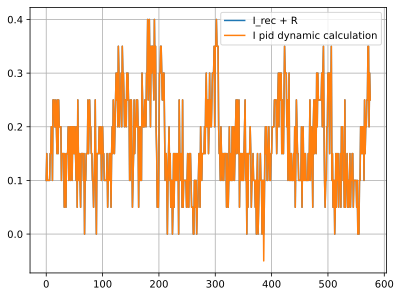

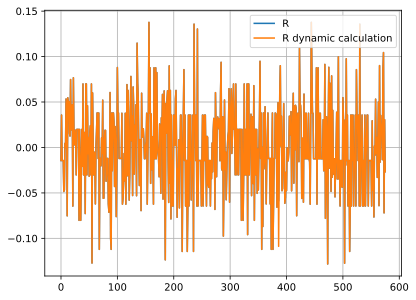

In [5]:
CGM   = (scaler_glucose.denormalize(dataset.CGM.detach())).numpy();              G     = (scaler_glucose.denormalize(dataset.G.detach())).numpy()
                                                                                                                                 
I_sat       = (scaler_insulin.denormalize(dataset.I_sat.detach())).numpy();      I_rec = (scaler_insulin.denormalize(dataset.I_rec.detach())).numpy();       
I_sat_rec   = (scaler_insulin.denormalize(dataset.I_sat_rec.detach())).numpy();  R     = (scaler_insulin.denormalize(dataset.R.detach())).numpy()

M       = (scaler_meal.denormalize(dataset.M.detach())).numpy();                 MH    = (scaler_meal.denormalize(dataset.MH.detach())).numpy();          
MH_rec  = (scaler_meal.denormalize(dataset.MH_rec.detach())).numpy()
H       = (scaler_meal.denormalize(dataset.H.detach())).numpy();                 H_rec = (scaler_meal.denormalize(dataset.H_rec.detach())).numpy();     

# R = I_sat (from .mat) - I_rec (exiting the PID and before saturation and noise)
# if  use_noise = True, R contains the noise and the saturation effect


# ------------------------- PID controller dynamic simulation ---------------------------------------------------
CGM_torch = dataset.CGM
loaded_parameters = Parameter(patient)
controller = NonLinearController(loaded_parameters, PID_functions, dataset.basal_vec, scaler_glucose, scaler_insulin, scaler_meal, use_noise)
u_pid, u_pid_rwgn, u_pid_rwgn_sat, r = controller(CGM_torch)


u_pid           = scaler_insulin.denormalize(u_pid.detach())
u_pid_rwgn      = scaler_insulin.denormalize(u_pid_rwgn.detach())
u_pid_rwgn_sat  = scaler_insulin.denormalize(u_pid_rwgn_sat.detach())
r               = scaler_insulin.denormalize(r.detach())

plt.figure()
plt.plot(I_rec[:2*1440//ts]+ R[:2*1440//ts], label= 'I_rec + R')
plt.plot(u_pid_rwgn_sat.numpy()[:2*1440//ts], label = 'I pid dynamic calculation');             plt.legend();plt.grid(True); plt.show()

plt.figure()
plt.plot(R[:2*1440//ts], label= 'R')
plt.plot(r.numpy()[:2*1440//ts], label = 'R dynamic calculation');                             plt.legend();plt.grid(True); plt.show()


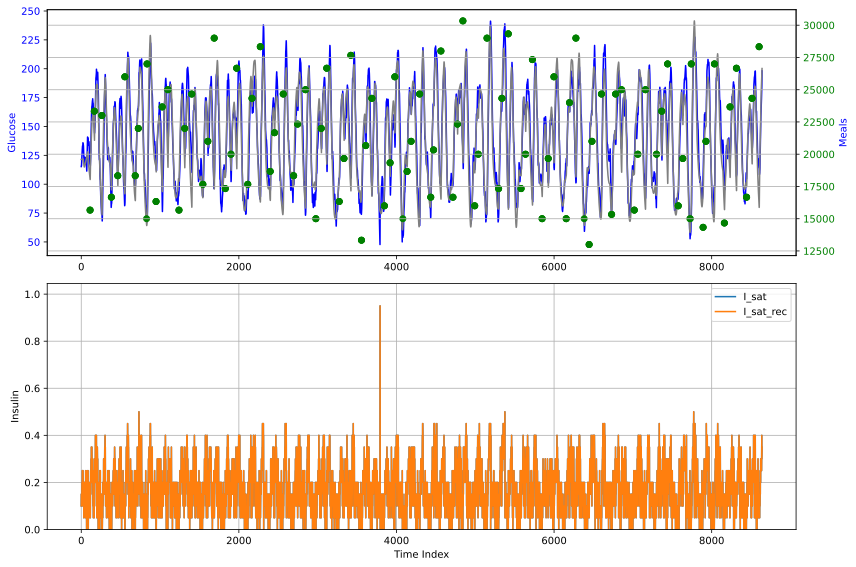

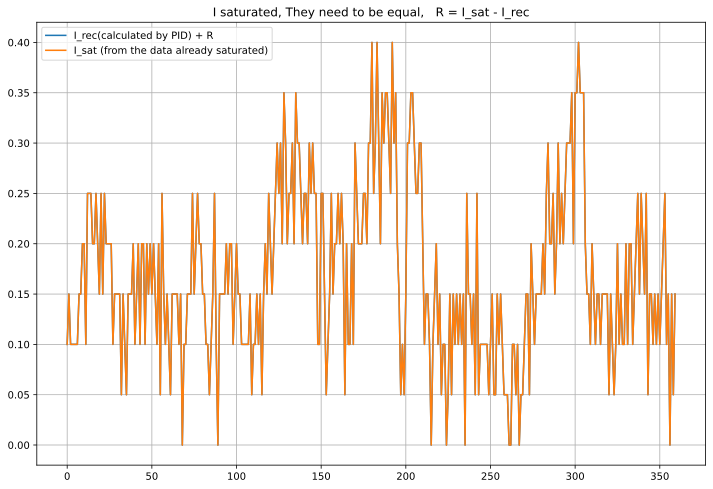

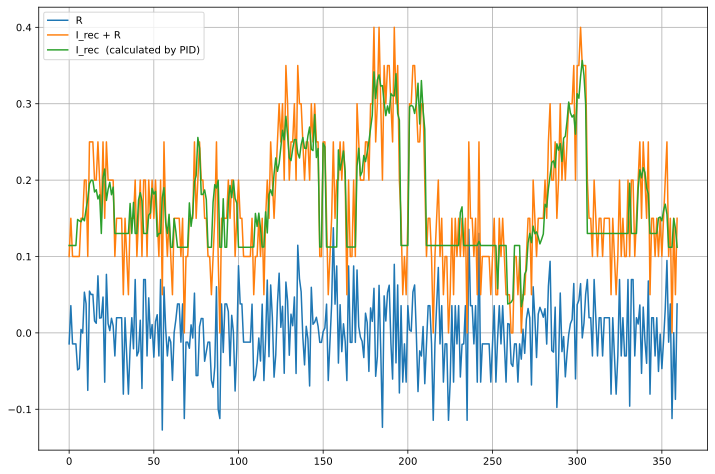

In [6]:
plt.figure(1, figsize=(12, 8))

# Subplot 1
ax1 = plt.subplot(2, 1, 1)
ax1.plot(CGM[:], 'b-', label='Glucose sensor CGM')
ax1.plot(G[:], 'gray', label='Glucose');                                                               ax1.set_ylabel('Glucose', color='b'); ax1.tick_params(axis='y', labelcolor='b'); ax1_right = ax1.twinx()
MHtemp = MH[:].copy()
ax1_right.scatter(np.arange(len(MHtemp))[MHtemp!=0], MHtemp[MHtemp!=0], color='g', label='Meals and hypo');         ax1_right.set_ylabel('Meals', color='b'); ax1_right.tick_params(axis='y', labelcolor='g'); plt.grid(True)

# Subplot 2
ax2 = plt.subplot(2, 1, 2, sharex=ax1)
ax2.plot(range(len(I_sat[:])), I_sat[:].flatten(), label='I_sat')
ax2.plot(range(len(I_sat_rec[:])), I_sat_rec[:], label='I_sat_rec');                                      ax2.set_ylim([0, np.max(I_sat_rec) * 1.1]); ax2.legend(); ax2.set_xlabel('Time Index'); ax2.set_ylabel('Insulin')

plt.tight_layout(); plt.grid(True); plt.show()



plt.figure(3, figsize=(12, 8))
plt.plot(I_rec[:1440//4]+ R[:1440//4], label = 'I_rec(calculated by PID) + R')
plt.plot(I_sat[:1440//4], label= 'I_sat (from the data already saturated)')
plt.title('I saturated, They need to be equal,   R = I_sat - I_rec');                   plt.legend();plt.grid(True); plt.show()

plt.figure(4, figsize=(12, 8))
plt.plot(R[:1440//4], label= 'R')
plt.plot(I_rec[:1440//4]+ R[:1440//4], label= 'I_rec + R')
plt.plot(I_rec[:1440//4], label = 'I_rec  (calculated by PID)');                             plt.legend();plt.grid(True); plt.show()


# plt.figure(5)
# plt.plot(H, label='H')
# plt.plot(H_rec-100, label='H_rec')
# plt.title('Hypoglycemia Treatments Comparison');                                                    plt.legend(); plt.show()
#
# plt.figure(6)
# plt.plot(CGM[:1440//4], 'b-', label='Glucose sensor CGM')
# plt.plot(G[:1440//4], 'gray', label='Glucose')
# plt.figure(1, figsize=(12, 8))


In [7]:
#--------------------------3. Define model for sysid---------------------------------------------


device = torch.device(device if torch.cuda.is_available() else "cpu")

# meal   M 
REN_0 = REN_IQC_gamma(dim_in= input_dim[0], dim_out= output_dim[0], dim_internal=dim_internal[0], dim_nl= dim_nl[0], y_init = y_init[0], QR_fun = set_QR, gammat=gamma[0], IQC_type = IQC_type[0], device=device)

# insulin  I_sat
REN_1 = REN_IQC_gamma(dim_in= input_dim[1], dim_out= output_dim[1], dim_internal=dim_internal[1], dim_nl= dim_nl[1], y_init = y_init[1], QR_fun = set_QR, gammat=gamma[1], IQC_type = IQC_type[1], device=device)

REN_0 = REN_0.to(device)
REN_1 = REN_1.to(device)

#create the closed loop with the identified model
# closed_loop_G = ClosedLoopSystem(REN_G, controller)

#--------------------------4. Define the loss function and optimizer---------------------------------------------
MSE = nn.MSELoss()

optimizer = torch.optim.Adam( list(REN_0.parameters()) + list(REN_1.parameters()),   lr=learning_rate)
optimizer.zero_grad()

C:\Users\pogotar\Desktop\Dottorato\Nonlinear_system_identification_modified\Nonlinear_system_identification_diabetic_patients\Rens.py:313: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:4419.)
  self.x = torch.linalg.lstsq(self.C2, y_init.squeeze(1).T)[0].T.unsqueeze(0).unsqueeze(0)


In [8]:
#--------------------------5. Training---------------------------------------------------------------------

torch.set_default_device(device)      # default tensor device
torch.set_default_dtype(torch.float32)  # default tensor dtype
print(f"[INFO] Training on device: {device}")

REN_0.to(device); REN_1.to(device)
train_losses = []
val_losses = []  # Store validation losses across epochs
for epoch in range(epochs):
    # ---------------- TRAINING ---------------- #
    REN_0.train(); REN_1.train()
    loss_epoch = 0.0  # Accumulate training loss

    
    for u0_batch, _, _, u1_batch, y_batch, _ in train_loader: # MH, I_rec (PID), R (noise + sat), I_sat (I_rec + R), CGM, time
        
        u0_batch, u1_batch, y_batch= ensure_3d(u0_batch), ensure_3d(u1_batch), ensure_3d(y_batch) # batch_size, time_horizon, input_dim
        u0_batch, u1_batch, y_batch = u0_batch.to(device), u1_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        REN_0.reset(); REN_1.reset()

        y0_hat_train = REN_0(u0_batch) # forward
        y1_hat_train = REN_1(u1_batch) # forward
        y_hat_train = y0_hat_train - y1_hat_train 
        # with monotonicity we have forced a positive response from the insulin REN (REN_1) 
        # but from real-world knowledge it is a negative relation

        loss_batch = MSE(y_hat_train, y_batch)

        loss_batch.backward()
        optimizer.step()
        loss_epoch += loss_batch.item()

    loss_epoch /= len(train_loader)
    train_losses.append(loss_epoch)

    # ---------------- VALIDATION ---------------- #
    REN_0.eval(); REN_1.eval()
    loss_val_epoch = 0.0

    with torch.no_grad():
        for u0_batch, _, _, u1_batch, y_batch, _ in val_loader: # MH, I_rec (PID), R (noise + sat), I_sat (I_rec + R), CGM, time

            u0_batch, u1_batch, y_batch= ensure_3d(u0_batch), ensure_3d(u1_batch), ensure_3d(y_batch)
            u0_batch, u1_batch, y_batch = u0_batch.to(device), u1_batch.to(device), y_batch.to(device)
            
            REN_0.reset(); REN_1.reset()

            y0_hat_val = REN_0(u0_batch)
            y1_hat_val = REN_1(u1_batch)# select the correct U
            y_hat_val = y0_hat_val - y1_hat_val
            
            loss_batch_val = MSE(y_hat_val, y_batch)

            loss_val_epoch += loss_batch_val.item()

    if epoch == 0 or loss_val_epoch < min_val_loss:
        min_val_loss = loss_val_epoch
        epoch_when_model_saved = epoch
        candidate_REN_0 = REN_0
        candidate_REN_1 = REN_1

    loss_val_epoch /= len(val_loader)
    val_losses.append(loss_val_epoch)  # Store validation loss for plotting

    print(f"Epoch: {epoch + 1} \t||\t Training Loss: {loss_epoch:.6f} \t||\t Validation Loss: {loss_val_epoch:.6f}")

if redo_save:
    # model on CPU before saving
    candidate_REN_0_cpu = candidate_REN_0.to('cpu')
    candidate_REN_1_cpu = candidate_REN_1.to('cpu')

    # Save the best model
    # 1. Create models directory
    patient_str = "/paz_" + str(int(patient)).zfill(3)
    patient_model_folder = model_folder + "/"+ "strategy_1" + "/" + patient_str
    MODEL_PATH = Path(patient_model_folder)
    MODEL_PATH.mkdir(parents = True, exist_ok = True)
    # 2. save model state dict
    torch.save({
    'REN_0_state_dict': candidate_REN_0_cpu.state_dict(),
    'REN_1_state_dict': candidate_REN_1_cpu.state_dict()}, MODEL_PATH / 'trained_models.pth')


    # save .mat
    np_x0 = x0.detach().cpu().numpy(); np_input_dim = np.array(input_dim); np_output_dim = np.array(output_dim); np_dim_internal =np.array(dim_internal); np_dim_nl = np.array(dim_nl)
    np_y_init = y_init.cpu().numpy(); np_gamma = gamma.cpu().numpy()
    
    # 4. Create params directory
    params_folder = Path(patient_model_folder) / "params"
    params_folder.mkdir(parents=True, exist_ok=True)
    scipy.io.savemat(params_folder / 'parameters.mat', {'train_losses': train_losses, 'val_losses': val_losses, 'epoch_when_model_saved': epoch_when_model_saved, 'x0': np_x0, 'input_dim': np_input_dim, 'output_dim': np_output_dim, 'dim_internal': np_dim_internal, 'dim_nl': np_dim_nl, 'y_init': np_y_init, 'gamma': np_gamma})


[INFO] Training on device: cpu


Epoch: 1 	||	 Training Loss: 0.280183 	||	 Validation Loss: 0.294282


Epoch: 2 	||	 Training Loss: 0.277607 	||	 Validation Loss: 0.291539


Epoch: 3 	||	 Training Loss: 0.275005 	||	 Validation Loss: 0.288769


Epoch: 4 	||	 Training Loss: 0.272377 	||	 Validation Loss: 0.285971


Epoch: 5 	||	 Training Loss: 0.269723 	||	 Validation Loss: 0.283144


Epoch: 6 	||	 Training Loss: 0.267041 	||	 Validation Loss: 0.280288


Epoch: 7 	||	 Training Loss: 0.264332 	||	 Validation Loss: 0.277400


Epoch: 8 	||	 Training Loss: 0.261592 	||	 Validation Loss: 0.274478


Epoch: 9 	||	 Training Loss: 0.258821 	||	 Validation Loss: 0.271519


Epoch: 10 	||	 Training Loss: 0.256014 	||	 Validation Loss: 0.268521


Epoch: 11 	||	 Training Loss: 0.253171 	||	 Validation Loss: 0.265479


Epoch: 12 	||	 Training Loss: 0.250286 	||	 Validation Loss: 0.262392


Epoch: 13 	||	 Training Loss: 0.247359 	||	 Validation Loss: 0.259257


Epoch: 14 	||	 Training Loss: 0.244386 	||	 Validation Loss: 0.256071


Epoch: 15 	||	 Training Loss: 0.241365 	||	 Validation Loss: 0.252834


Epoch: 16 	||	 Training Loss: 0.238295 	||	 Validation Loss: 0.249542


Epoch: 17 	||	 Training Loss: 0.235174 	||	 Validation Loss: 0.246196


Epoch: 18 	||	 Training Loss: 0.232001 	||	 Validation Loss: 0.242792


Epoch: 19 	||	 Training Loss: 0.228775 	||	 Validation Loss: 0.239331


Epoch: 20 	||	 Training Loss: 0.225493 	||	 Validation Loss: 0.235810


Epoch: 21 	||	 Training Loss: 0.222156 	||	 Validation Loss: 0.232227


Epoch: 22 	||	 Training Loss: 0.218760 	||	 Validation Loss: 0.228583


Epoch: 23 	||	 Training Loss: 0.215305 	||	 Validation Loss: 0.224875


Epoch: 24 	||	 Training Loss: 0.211791 	||	 Validation Loss: 0.221102


Epoch: 25 	||	 Training Loss: 0.208215 	||	 Validation Loss: 0.217264


Epoch: 26 	||	 Training Loss: 0.204578 	||	 Validation Loss: 0.213361


Epoch: 27 	||	 Training Loss: 0.200879 	||	 Validation Loss: 0.209391


Epoch: 28 	||	 Training Loss: 0.197118 	||	 Validation Loss: 0.205355


Epoch: 29 	||	 Training Loss: 0.193294 	||	 Validation Loss: 0.201253


Epoch: 30 	||	 Training Loss: 0.189408 	||	 Validation Loss: 0.197085


Epoch: 31 	||	 Training Loss: 0.185461 	||	 Validation Loss: 0.192852


Epoch: 32 	||	 Training Loss: 0.181452 	||	 Validation Loss: 0.188556


Epoch: 33 	||	 Training Loss: 0.177383 	||	 Validation Loss: 0.184197


Epoch: 34 	||	 Training Loss: 0.173256 	||	 Validation Loss: 0.179776


Epoch: 35 	||	 Training Loss: 0.169071 	||	 Validation Loss: 0.175296


Epoch: 36 	||	 Training Loss: 0.164831 	||	 Validation Loss: 0.170759


Epoch: 37 	||	 Training Loss: 0.160537 	||	 Validation Loss: 0.166166


Epoch: 38 	||	 Training Loss: 0.156192 	||	 Validation Loss: 0.161521


Epoch: 39 	||	 Training Loss: 0.151797 	||	 Validation Loss: 0.156825


Epoch: 40 	||	 Training Loss: 0.147357 	||	 Validation Loss: 0.152083


Epoch: 41 	||	 Training Loss: 0.142873 	||	 Validation Loss: 0.147297


Epoch: 42 	||	 Training Loss: 0.138349 	||	 Validation Loss: 0.142471


Epoch: 43 	||	 Training Loss: 0.133788 	||	 Validation Loss: 0.137609


Epoch: 44 	||	 Training Loss: 0.129196 	||	 Validation Loss: 0.132717


Epoch: 45 	||	 Training Loss: 0.124576 	||	 Validation Loss: 0.127799


Epoch: 46 	||	 Training Loss: 0.119934 	||	 Validation Loss: 0.122862


Epoch: 47 	||	 Training Loss: 0.115275 	||	 Validation Loss: 0.117912


Epoch: 48 	||	 Training Loss: 0.110606 	||	 Validation Loss: 0.112956


Epoch: 49 	||	 Training Loss: 0.105934 	||	 Validation Loss: 0.108002


Epoch: 50 	||	 Training Loss: 0.101266 	||	 Validation Loss: 0.103059


Epoch: 51 	||	 Training Loss: 0.096611 	||	 Validation Loss: 0.098137


Epoch: 52 	||	 Training Loss: 0.091978 	||	 Validation Loss: 0.093245


Epoch: 53 	||	 Training Loss: 0.087378 	||	 Validation Loss: 0.088395


Epoch: 54 	||	 Training Loss: 0.082820 	||	 Validation Loss: 0.083599


Epoch: 55 	||	 Training Loss: 0.078316 	||	 Validation Loss: 0.078868


Epoch: 56 	||	 Training Loss: 0.073879 	||	 Validation Loss: 0.074217


Epoch: 57 	||	 Training Loss: 0.069520 	||	 Validation Loss: 0.069658


Epoch: 58 	||	 Training Loss: 0.065252 	||	 Validation Loss: 0.065206


Epoch: 59 	||	 Training Loss: 0.061090 	||	 Validation Loss: 0.060875


Epoch: 60 	||	 Training Loss: 0.057048 	||	 Validation Loss: 0.056681


Epoch: 61 	||	 Training Loss: 0.053140 	||	 Validation Loss: 0.052639


Epoch: 62 	||	 Training Loss: 0.049380 	||	 Validation Loss: 0.048764


Epoch: 63 	||	 Training Loss: 0.045785 	||	 Validation Loss: 0.045072


Epoch: 64 	||	 Training Loss: 0.042367 	||	 Validation Loss: 0.041579


Epoch: 65 	||	 Training Loss: 0.039143 	||	 Validation Loss: 0.038299


Epoch: 66 	||	 Training Loss: 0.036127 	||	 Validation Loss: 0.035248


Epoch: 67 	||	 Training Loss: 0.033333 	||	 Validation Loss: 0.032438


Epoch: 68 	||	 Training Loss: 0.030773 	||	 Validation Loss: 0.029882


Epoch: 69 	||	 Training Loss: 0.028459 	||	 Validation Loss: 0.027590


Epoch: 70 	||	 Training Loss: 0.026399 	||	 Validation Loss: 0.025569


Epoch: 71 	||	 Training Loss: 0.024601 	||	 Validation Loss: 0.023824


Epoch: 72 	||	 Training Loss: 0.023067 	||	 Validation Loss: 0.022353


Epoch: 73 	||	 Training Loss: 0.021797 	||	 Validation Loss: 0.021152


Epoch: 74 	||	 Training Loss: 0.020784 	||	 Validation Loss: 0.020210


Epoch: 75 	||	 Training Loss: 0.020018 	||	 Validation Loss: 0.019511


Epoch: 76 	||	 Training Loss: 0.019480 	||	 Validation Loss: 0.019032


Epoch: 77 	||	 Training Loss: 0.019149 	||	 Validation Loss: 0.018743


Epoch: 78 	||	 Training Loss: 0.018994 	||	 Validation Loss: 0.018614


Epoch: 79 	||	 Training Loss: 0.018984 	||	 Validation Loss: 0.018606


Epoch: 80 	||	 Training Loss: 0.019080 	||	 Validation Loss: 0.018681


Epoch: 81 	||	 Training Loss: 0.019247 	||	 Validation Loss: 0.018805


Epoch: 82 	||	 Training Loss: 0.019446 	||	 Validation Loss: 0.018941


Epoch: 83 	||	 Training Loss: 0.019646 	||	 Validation Loss: 0.019064


Epoch: 84 	||	 Training Loss: 0.019818 	||	 Validation Loss: 0.019151


Epoch: 85 	||	 Training Loss: 0.019943 	||	 Validation Loss: 0.019188


Epoch: 86 	||	 Training Loss: 0.020006 	||	 Validation Loss: 0.019170


Epoch: 87 	||	 Training Loss: 0.020004 	||	 Validation Loss: 0.019098


Epoch: 88 	||	 Training Loss: 0.019938 	||	 Validation Loss: 0.018978


Epoch: 89 	||	 Training Loss: 0.019814 	||	 Validation Loss: 0.018821


Epoch: 90 	||	 Training Loss: 0.019646 	||	 Validation Loss: 0.018638


Epoch: 91 	||	 Training Loss: 0.019444 	||	 Validation Loss: 0.018442


Epoch: 92 	||	 Training Loss: 0.019225 	||	 Validation Loss: 0.018247


Epoch: 93 	||	 Training Loss: 0.018999 	||	 Validation Loss: 0.018060


Epoch: 94 	||	 Training Loss: 0.018779 	||	 Validation Loss: 0.017892


Epoch: 95 	||	 Training Loss: 0.018574 	||	 Validation Loss: 0.017746


Epoch: 96 	||	 Training Loss: 0.018389 	||	 Validation Loss: 0.017625


Epoch: 97 	||	 Training Loss: 0.018228 	||	 Validation Loss: 0.017531


Epoch: 98 	||	 Training Loss: 0.018093 	||	 Validation Loss: 0.017461


Epoch: 99 	||	 Training Loss: 0.017983 	||	 Validation Loss: 0.017412


Epoch: 100 	||	 Training Loss: 0.017896 	||	 Validation Loss: 0.017382


Epoch: 101 	||	 Training Loss: 0.017828 	||	 Validation Loss: 0.017364


Epoch: 102 	||	 Training Loss: 0.017776 	||	 Validation Loss: 0.017356


Epoch: 103 	||	 Training Loss: 0.017736 	||	 Validation Loss: 0.017353


Epoch: 104 	||	 Training Loss: 0.017704 	||	 Validation Loss: 0.017351


Epoch: 105 	||	 Training Loss: 0.017677 	||	 Validation Loss: 0.017347


Epoch: 106 	||	 Training Loss: 0.017651 	||	 Validation Loss: 0.017338


Epoch: 107 	||	 Training Loss: 0.017624 	||	 Validation Loss: 0.017322


Epoch: 108 	||	 Training Loss: 0.017594 	||	 Validation Loss: 0.017299


Epoch: 109 	||	 Training Loss: 0.017560 	||	 Validation Loss: 0.017268


Epoch: 110 	||	 Training Loss: 0.017522 	||	 Validation Loss: 0.017228


Epoch: 111 	||	 Training Loss: 0.017479 	||	 Validation Loss: 0.017181


Epoch: 112 	||	 Training Loss: 0.017431 	||	 Validation Loss: 0.017126


Epoch: 113 	||	 Training Loss: 0.017379 	||	 Validation Loss: 0.017066


Epoch: 114 	||	 Training Loss: 0.017323 	||	 Validation Loss: 0.017000


Epoch: 115 	||	 Training Loss: 0.017265 	||	 Validation Loss: 0.016931


Epoch: 116 	||	 Training Loss: 0.017205 	||	 Validation Loss: 0.016860


Epoch: 117 	||	 Training Loss: 0.017145 	||	 Validation Loss: 0.016787


Epoch: 118 	||	 Training Loss: 0.017084 	||	 Validation Loss: 0.016714


Epoch: 119 	||	 Training Loss: 0.017024 	||	 Validation Loss: 0.016642


Epoch: 120 	||	 Training Loss: 0.016965 	||	 Validation Loss: 0.016571


Epoch: 121 	||	 Training Loss: 0.016908 	||	 Validation Loss: 0.016501


Epoch: 122 	||	 Training Loss: 0.016852 	||	 Validation Loss: 0.016434


Epoch: 123 	||	 Training Loss: 0.016799 	||	 Validation Loss: 0.016369


Epoch: 124 	||	 Training Loss: 0.016747 	||	 Validation Loss: 0.016306


Epoch: 125 	||	 Training Loss: 0.016697 	||	 Validation Loss: 0.016245


Epoch: 126 	||	 Training Loss: 0.016648 	||	 Validation Loss: 0.016187


Epoch: 127 	||	 Training Loss: 0.016601 	||	 Validation Loss: 0.016130


Epoch: 128 	||	 Training Loss: 0.016554 	||	 Validation Loss: 0.016076


Epoch: 129 	||	 Training Loss: 0.016508 	||	 Validation Loss: 0.016023


Epoch: 130 	||	 Training Loss: 0.016463 	||	 Validation Loss: 0.015971


Epoch: 131 	||	 Training Loss: 0.016418 	||	 Validation Loss: 0.015921


Epoch: 132 	||	 Training Loss: 0.016372 	||	 Validation Loss: 0.015872


Epoch: 133 	||	 Training Loss: 0.016327 	||	 Validation Loss: 0.015823


Epoch: 134 	||	 Training Loss: 0.016281 	||	 Validation Loss: 0.015776


Epoch: 135 	||	 Training Loss: 0.016235 	||	 Validation Loss: 0.015729


Epoch: 136 	||	 Training Loss: 0.016188 	||	 Validation Loss: 0.015683


Epoch: 137 	||	 Training Loss: 0.016142 	||	 Validation Loss: 0.015638


Epoch: 138 	||	 Training Loss: 0.016095 	||	 Validation Loss: 0.015594


Epoch: 139 	||	 Training Loss: 0.016048 	||	 Validation Loss: 0.015550


Epoch: 140 	||	 Training Loss: 0.016002 	||	 Validation Loss: 0.015507


Epoch: 141 	||	 Training Loss: 0.015955 	||	 Validation Loss: 0.015464


Epoch: 142 	||	 Training Loss: 0.015909 	||	 Validation Loss: 0.015422


Epoch: 143 	||	 Training Loss: 0.015863 	||	 Validation Loss: 0.015380


Epoch: 144 	||	 Training Loss: 0.015817 	||	 Validation Loss: 0.015339


Epoch: 145 	||	 Training Loss: 0.015771 	||	 Validation Loss: 0.015297


Epoch: 146 	||	 Training Loss: 0.015725 	||	 Validation Loss: 0.015256


Epoch: 147 	||	 Training Loss: 0.015680 	||	 Validation Loss: 0.015215


Epoch: 148 	||	 Training Loss: 0.015635 	||	 Validation Loss: 0.015174


Epoch: 149 	||	 Training Loss: 0.015591 	||	 Validation Loss: 0.015133


Epoch: 150 	||	 Training Loss: 0.015546 	||	 Validation Loss: 0.015091


Epoch: 151 	||	 Training Loss: 0.015502 	||	 Validation Loss: 0.015049


Epoch: 152 	||	 Training Loss: 0.015457 	||	 Validation Loss: 0.015007


Epoch: 153 	||	 Training Loss: 0.015413 	||	 Validation Loss: 0.014965


Epoch: 154 	||	 Training Loss: 0.015369 	||	 Validation Loss: 0.014922


Epoch: 155 	||	 Training Loss: 0.015325 	||	 Validation Loss: 0.014878


Epoch: 156 	||	 Training Loss: 0.015281 	||	 Validation Loss: 0.014835


Epoch: 157 	||	 Training Loss: 0.015237 	||	 Validation Loss: 0.014791


Epoch: 158 	||	 Training Loss: 0.015193 	||	 Validation Loss: 0.014747


Epoch: 159 	||	 Training Loss: 0.015149 	||	 Validation Loss: 0.014703


Epoch: 160 	||	 Training Loss: 0.015105 	||	 Validation Loss: 0.014658


Epoch: 161 	||	 Training Loss: 0.015061 	||	 Validation Loss: 0.014613


Epoch: 162 	||	 Training Loss: 0.015018 	||	 Validation Loss: 0.014569


Epoch: 163 	||	 Training Loss: 0.014974 	||	 Validation Loss: 0.014524


Epoch: 164 	||	 Training Loss: 0.014930 	||	 Validation Loss: 0.014479


Epoch: 165 	||	 Training Loss: 0.014887 	||	 Validation Loss: 0.014435


Epoch: 166 	||	 Training Loss: 0.014844 	||	 Validation Loss: 0.014390


Epoch: 167 	||	 Training Loss: 0.014800 	||	 Validation Loss: 0.014346


Epoch: 168 	||	 Training Loss: 0.014757 	||	 Validation Loss: 0.014302


Epoch: 169 	||	 Training Loss: 0.014714 	||	 Validation Loss: 0.014258


Epoch: 170 	||	 Training Loss: 0.014671 	||	 Validation Loss: 0.014215


Epoch: 171 	||	 Training Loss: 0.014628 	||	 Validation Loss: 0.014172


Epoch: 172 	||	 Training Loss: 0.014585 	||	 Validation Loss: 0.014129


Epoch: 173 	||	 Training Loss: 0.014543 	||	 Validation Loss: 0.014086


Epoch: 174 	||	 Training Loss: 0.014500 	||	 Validation Loss: 0.014044


Epoch: 175 	||	 Training Loss: 0.014458 	||	 Validation Loss: 0.014001


Epoch: 176 	||	 Training Loss: 0.014415 	||	 Validation Loss: 0.013960


Epoch: 177 	||	 Training Loss: 0.014373 	||	 Validation Loss: 0.013918


Epoch: 178 	||	 Training Loss: 0.014331 	||	 Validation Loss: 0.013877


Epoch: 179 	||	 Training Loss: 0.014289 	||	 Validation Loss: 0.013836


Epoch: 180 	||	 Training Loss: 0.014247 	||	 Validation Loss: 0.013795


Epoch: 181 	||	 Training Loss: 0.014205 	||	 Validation Loss: 0.013755


Epoch: 182 	||	 Training Loss: 0.014163 	||	 Validation Loss: 0.013714


Epoch: 183 	||	 Training Loss: 0.014121 	||	 Validation Loss: 0.013674


Epoch: 184 	||	 Training Loss: 0.014080 	||	 Validation Loss: 0.013634


Epoch: 185 	||	 Training Loss: 0.014038 	||	 Validation Loss: 0.013594


Epoch: 186 	||	 Training Loss: 0.013997 	||	 Validation Loss: 0.013554


Epoch: 187 	||	 Training Loss: 0.013956 	||	 Validation Loss: 0.013515


Epoch: 188 	||	 Training Loss: 0.013914 	||	 Validation Loss: 0.013475


Epoch: 189 	||	 Training Loss: 0.013873 	||	 Validation Loss: 0.013436


Epoch: 190 	||	 Training Loss: 0.013832 	||	 Validation Loss: 0.013397


Epoch: 191 	||	 Training Loss: 0.013792 	||	 Validation Loss: 0.013357


Epoch: 192 	||	 Training Loss: 0.013751 	||	 Validation Loss: 0.013318


Epoch: 193 	||	 Training Loss: 0.013710 	||	 Validation Loss: 0.013279


Epoch: 194 	||	 Training Loss: 0.013670 	||	 Validation Loss: 0.013240


Epoch: 195 	||	 Training Loss: 0.013629 	||	 Validation Loss: 0.013201


Epoch: 196 	||	 Training Loss: 0.013589 	||	 Validation Loss: 0.013163


Epoch: 197 	||	 Training Loss: 0.013549 	||	 Validation Loss: 0.013124


Epoch: 198 	||	 Training Loss: 0.013509 	||	 Validation Loss: 0.013085


Epoch: 199 	||	 Training Loss: 0.013469 	||	 Validation Loss: 0.013047


Epoch: 200 	||	 Training Loss: 0.013429 	||	 Validation Loss: 0.013008


Epoch: 201 	||	 Training Loss: 0.013389 	||	 Validation Loss: 0.012970


Epoch: 202 	||	 Training Loss: 0.013350 	||	 Validation Loss: 0.012932


Epoch: 203 	||	 Training Loss: 0.013310 	||	 Validation Loss: 0.012894


Epoch: 204 	||	 Training Loss: 0.013271 	||	 Validation Loss: 0.012856


Epoch: 205 	||	 Training Loss: 0.013232 	||	 Validation Loss: 0.012818


Epoch: 206 	||	 Training Loss: 0.013192 	||	 Validation Loss: 0.012781


Epoch: 207 	||	 Training Loss: 0.013153 	||	 Validation Loss: 0.012744


Epoch: 208 	||	 Training Loss: 0.013115 	||	 Validation Loss: 0.012706


Epoch: 209 	||	 Training Loss: 0.013076 	||	 Validation Loss: 0.012669


Epoch: 210 	||	 Training Loss: 0.013037 	||	 Validation Loss: 0.012632


Epoch: 211 	||	 Training Loss: 0.012998 	||	 Validation Loss: 0.012596


Epoch: 212 	||	 Training Loss: 0.012960 	||	 Validation Loss: 0.012559


Epoch: 213 	||	 Training Loss: 0.012922 	||	 Validation Loss: 0.012523


Epoch: 214 	||	 Training Loss: 0.012884 	||	 Validation Loss: 0.012487


Epoch: 215 	||	 Training Loss: 0.012845 	||	 Validation Loss: 0.012451


Epoch: 216 	||	 Training Loss: 0.012807 	||	 Validation Loss: 0.012415


Epoch: 217 	||	 Training Loss: 0.012770 	||	 Validation Loss: 0.012379


Epoch: 218 	||	 Training Loss: 0.012732 	||	 Validation Loss: 0.012344


Epoch: 219 	||	 Training Loss: 0.012694 	||	 Validation Loss: 0.012308


Epoch: 220 	||	 Training Loss: 0.012657 	||	 Validation Loss: 0.012273


Epoch: 221 	||	 Training Loss: 0.012619 	||	 Validation Loss: 0.012238


Epoch: 222 	||	 Training Loss: 0.012582 	||	 Validation Loss: 0.012203


Epoch: 223 	||	 Training Loss: 0.012545 	||	 Validation Loss: 0.012168


Epoch: 224 	||	 Training Loss: 0.012508 	||	 Validation Loss: 0.012134


Epoch: 225 	||	 Training Loss: 0.012471 	||	 Validation Loss: 0.012099


Epoch: 226 	||	 Training Loss: 0.012435 	||	 Validation Loss: 0.012065


Epoch: 227 	||	 Training Loss: 0.012398 	||	 Validation Loss: 0.012031


Epoch: 228 	||	 Training Loss: 0.012362 	||	 Validation Loss: 0.011997


Epoch: 229 	||	 Training Loss: 0.012325 	||	 Validation Loss: 0.011963


Epoch: 230 	||	 Training Loss: 0.012289 	||	 Validation Loss: 0.011930


Epoch: 231 	||	 Training Loss: 0.012253 	||	 Validation Loss: 0.011896


Epoch: 232 	||	 Training Loss: 0.012217 	||	 Validation Loss: 0.011863


Epoch: 233 	||	 Training Loss: 0.012181 	||	 Validation Loss: 0.011829


Epoch: 234 	||	 Training Loss: 0.012145 	||	 Validation Loss: 0.011796


Epoch: 235 	||	 Training Loss: 0.012110 	||	 Validation Loss: 0.011763


Epoch: 236 	||	 Training Loss: 0.012074 	||	 Validation Loss: 0.011731


Epoch: 237 	||	 Training Loss: 0.012039 	||	 Validation Loss: 0.011698


Epoch: 238 	||	 Training Loss: 0.012004 	||	 Validation Loss: 0.011666


Epoch: 239 	||	 Training Loss: 0.011969 	||	 Validation Loss: 0.011633


Epoch: 240 	||	 Training Loss: 0.011934 	||	 Validation Loss: 0.011601


Epoch: 241 	||	 Training Loss: 0.011899 	||	 Validation Loss: 0.011569


Epoch: 242 	||	 Training Loss: 0.011864 	||	 Validation Loss: 0.011537


Epoch: 243 	||	 Training Loss: 0.011830 	||	 Validation Loss: 0.011506


Epoch: 244 	||	 Training Loss: 0.011796 	||	 Validation Loss: 0.011474


Epoch: 245 	||	 Training Loss: 0.011761 	||	 Validation Loss: 0.011443


Epoch: 246 	||	 Training Loss: 0.011727 	||	 Validation Loss: 0.011412


Epoch: 247 	||	 Training Loss: 0.011693 	||	 Validation Loss: 0.011381


Epoch: 248 	||	 Training Loss: 0.011659 	||	 Validation Loss: 0.011350


Epoch: 249 	||	 Training Loss: 0.011626 	||	 Validation Loss: 0.011319


Epoch: 250 	||	 Training Loss: 0.011592 	||	 Validation Loss: 0.011289


Epoch: 251 	||	 Training Loss: 0.011559 	||	 Validation Loss: 0.011258


Epoch: 252 	||	 Training Loss: 0.011525 	||	 Validation Loss: 0.011228


Epoch: 253 	||	 Training Loss: 0.011492 	||	 Validation Loss: 0.011198


Epoch: 254 	||	 Training Loss: 0.011459 	||	 Validation Loss: 0.011168


Epoch: 255 	||	 Training Loss: 0.011426 	||	 Validation Loss: 0.011139


Epoch: 256 	||	 Training Loss: 0.011393 	||	 Validation Loss: 0.011109


Epoch: 257 	||	 Training Loss: 0.011361 	||	 Validation Loss: 0.011080


Epoch: 258 	||	 Training Loss: 0.011328 	||	 Validation Loss: 0.011050


Epoch: 259 	||	 Training Loss: 0.011296 	||	 Validation Loss: 0.011021


Epoch: 260 	||	 Training Loss: 0.011264 	||	 Validation Loss: 0.010992


Epoch: 261 	||	 Training Loss: 0.011231 	||	 Validation Loss: 0.010964


Epoch: 262 	||	 Training Loss: 0.011199 	||	 Validation Loss: 0.010935


Epoch: 263 	||	 Training Loss: 0.011168 	||	 Validation Loss: 0.010907


Epoch: 264 	||	 Training Loss: 0.011136 	||	 Validation Loss: 0.010878


Epoch: 265 	||	 Training Loss: 0.011104 	||	 Validation Loss: 0.010850


Epoch: 266 	||	 Training Loss: 0.011073 	||	 Validation Loss: 0.010822


Epoch: 267 	||	 Training Loss: 0.011042 	||	 Validation Loss: 0.010795


Epoch: 268 	||	 Training Loss: 0.011011 	||	 Validation Loss: 0.010767


Epoch: 269 	||	 Training Loss: 0.010980 	||	 Validation Loss: 0.010740


Epoch: 270 	||	 Training Loss: 0.010949 	||	 Validation Loss: 0.010712


Epoch: 271 	||	 Training Loss: 0.010918 	||	 Validation Loss: 0.010685


Epoch: 272 	||	 Training Loss: 0.010887 	||	 Validation Loss: 0.010658


Epoch: 273 	||	 Training Loss: 0.010857 	||	 Validation Loss: 0.010631


Epoch: 274 	||	 Training Loss: 0.010827 	||	 Validation Loss: 0.010605


Epoch: 275 	||	 Training Loss: 0.010796 	||	 Validation Loss: 0.010578


Epoch: 276 	||	 Training Loss: 0.010766 	||	 Validation Loss: 0.010552


Epoch: 277 	||	 Training Loss: 0.010736 	||	 Validation Loss: 0.010526


Epoch: 278 	||	 Training Loss: 0.010707 	||	 Validation Loss: 0.010500


Epoch: 279 	||	 Training Loss: 0.010677 	||	 Validation Loss: 0.010474


Epoch: 280 	||	 Training Loss: 0.010648 	||	 Validation Loss: 0.010448


Epoch: 281 	||	 Training Loss: 0.010618 	||	 Validation Loss: 0.010423


Epoch: 282 	||	 Training Loss: 0.010589 	||	 Validation Loss: 0.010397


Epoch: 283 	||	 Training Loss: 0.010560 	||	 Validation Loss: 0.010372


Epoch: 284 	||	 Training Loss: 0.010531 	||	 Validation Loss: 0.010347


Epoch: 285 	||	 Training Loss: 0.010502 	||	 Validation Loss: 0.010322


Epoch: 286 	||	 Training Loss: 0.010474 	||	 Validation Loss: 0.010297


Epoch: 287 	||	 Training Loss: 0.010445 	||	 Validation Loss: 0.010273


Epoch: 288 	||	 Training Loss: 0.010417 	||	 Validation Loss: 0.010248


Epoch: 289 	||	 Training Loss: 0.010388 	||	 Validation Loss: 0.010224


Epoch: 290 	||	 Training Loss: 0.010360 	||	 Validation Loss: 0.010200


Epoch: 291 	||	 Training Loss: 0.010332 	||	 Validation Loss: 0.010176


Epoch: 292 	||	 Training Loss: 0.010305 	||	 Validation Loss: 0.010152


Epoch: 293 	||	 Training Loss: 0.010277 	||	 Validation Loss: 0.010129


Epoch: 294 	||	 Training Loss: 0.010249 	||	 Validation Loss: 0.010105


Epoch: 295 	||	 Training Loss: 0.010222 	||	 Validation Loss: 0.010082


Epoch: 296 	||	 Training Loss: 0.010195 	||	 Validation Loss: 0.010059


Epoch: 297 	||	 Training Loss: 0.010167 	||	 Validation Loss: 0.010036


Epoch: 298 	||	 Training Loss: 0.010141 	||	 Validation Loss: 0.010013


Epoch: 299 	||	 Training Loss: 0.010114 	||	 Validation Loss: 0.009990


Epoch: 300 	||	 Training Loss: 0.010087 	||	 Validation Loss: 0.009968


Epoch: 301 	||	 Training Loss: 0.010060 	||	 Validation Loss: 0.009945


Epoch: 302 	||	 Training Loss: 0.010034 	||	 Validation Loss: 0.009923


Epoch: 303 	||	 Training Loss: 0.010008 	||	 Validation Loss: 0.009901


Epoch: 304 	||	 Training Loss: 0.009981 	||	 Validation Loss: 0.009879


Epoch: 305 	||	 Training Loss: 0.009955 	||	 Validation Loss: 0.009857


Epoch: 306 	||	 Training Loss: 0.009930 	||	 Validation Loss: 0.009836


Epoch: 307 	||	 Training Loss: 0.009904 	||	 Validation Loss: 0.009814


Epoch: 308 	||	 Training Loss: 0.009878 	||	 Validation Loss: 0.009793


Epoch: 309 	||	 Training Loss: 0.009853 	||	 Validation Loss: 0.009772


Epoch: 310 	||	 Training Loss: 0.009827 	||	 Validation Loss: 0.009751


Epoch: 311 	||	 Training Loss: 0.009802 	||	 Validation Loss: 0.009730


Epoch: 312 	||	 Training Loss: 0.009777 	||	 Validation Loss: 0.009709


Epoch: 313 	||	 Training Loss: 0.009752 	||	 Validation Loss: 0.009689


Epoch: 314 	||	 Training Loss: 0.009728 	||	 Validation Loss: 0.009669


Epoch: 315 	||	 Training Loss: 0.009703 	||	 Validation Loss: 0.009648


Epoch: 316 	||	 Training Loss: 0.009678 	||	 Validation Loss: 0.009628


Epoch: 317 	||	 Training Loss: 0.009654 	||	 Validation Loss: 0.009608


Epoch: 318 	||	 Training Loss: 0.009630 	||	 Validation Loss: 0.009589


Epoch: 319 	||	 Training Loss: 0.009606 	||	 Validation Loss: 0.009569


Epoch: 320 	||	 Training Loss: 0.009582 	||	 Validation Loss: 0.009550


Epoch: 321 	||	 Training Loss: 0.009558 	||	 Validation Loss: 0.009530


Epoch: 322 	||	 Training Loss: 0.009534 	||	 Validation Loss: 0.009511


Epoch: 323 	||	 Training Loss: 0.009511 	||	 Validation Loss: 0.009492


Epoch: 324 	||	 Training Loss: 0.009487 	||	 Validation Loss: 0.009473


Epoch: 325 	||	 Training Loss: 0.009464 	||	 Validation Loss: 0.009454


Epoch: 326 	||	 Training Loss: 0.009441 	||	 Validation Loss: 0.009436


Epoch: 327 	||	 Training Loss: 0.009418 	||	 Validation Loss: 0.009417


Epoch: 328 	||	 Training Loss: 0.009395 	||	 Validation Loss: 0.009399


Epoch: 329 	||	 Training Loss: 0.009372 	||	 Validation Loss: 0.009381


Epoch: 330 	||	 Training Loss: 0.009350 	||	 Validation Loss: 0.009363


Epoch: 331 	||	 Training Loss: 0.009327 	||	 Validation Loss: 0.009345


Epoch: 332 	||	 Training Loss: 0.009305 	||	 Validation Loss: 0.009328


Epoch: 333 	||	 Training Loss: 0.009283 	||	 Validation Loss: 0.009310


Epoch: 334 	||	 Training Loss: 0.009261 	||	 Validation Loss: 0.009293


Epoch: 335 	||	 Training Loss: 0.009239 	||	 Validation Loss: 0.009275


Epoch: 336 	||	 Training Loss: 0.009217 	||	 Validation Loss: 0.009258


Epoch: 337 	||	 Training Loss: 0.009196 	||	 Validation Loss: 0.009241


Epoch: 338 	||	 Training Loss: 0.009174 	||	 Validation Loss: 0.009225


Epoch: 339 	||	 Training Loss: 0.009153 	||	 Validation Loss: 0.009208


Epoch: 340 	||	 Training Loss: 0.009131 	||	 Validation Loss: 0.009191


Epoch: 341 	||	 Training Loss: 0.009110 	||	 Validation Loss: 0.009175


Epoch: 342 	||	 Training Loss: 0.009089 	||	 Validation Loss: 0.009159


Epoch: 343 	||	 Training Loss: 0.009069 	||	 Validation Loss: 0.009143


Epoch: 344 	||	 Training Loss: 0.009048 	||	 Validation Loss: 0.009127


Epoch: 345 	||	 Training Loss: 0.009027 	||	 Validation Loss: 0.009111


Epoch: 346 	||	 Training Loss: 0.009007 	||	 Validation Loss: 0.009095


Epoch: 347 	||	 Training Loss: 0.008987 	||	 Validation Loss: 0.009080


Epoch: 348 	||	 Training Loss: 0.008966 	||	 Validation Loss: 0.009064


Epoch: 349 	||	 Training Loss: 0.008946 	||	 Validation Loss: 0.009049


Epoch: 350 	||	 Training Loss: 0.008927 	||	 Validation Loss: 0.009034


Epoch: 351 	||	 Training Loss: 0.008907 	||	 Validation Loss: 0.009019


Epoch: 352 	||	 Training Loss: 0.008887 	||	 Validation Loss: 0.009004


Epoch: 353 	||	 Training Loss: 0.008868 	||	 Validation Loss: 0.008989


Epoch: 354 	||	 Training Loss: 0.008848 	||	 Validation Loss: 0.008975


Epoch: 355 	||	 Training Loss: 0.008829 	||	 Validation Loss: 0.008960


Epoch: 356 	||	 Training Loss: 0.008810 	||	 Validation Loss: 0.008946


Epoch: 357 	||	 Training Loss: 0.008791 	||	 Validation Loss: 0.008932


Epoch: 358 	||	 Training Loss: 0.008772 	||	 Validation Loss: 0.008918


Epoch: 359 	||	 Training Loss: 0.008753 	||	 Validation Loss: 0.008904


Epoch: 360 	||	 Training Loss: 0.008735 	||	 Validation Loss: 0.008890


Epoch: 361 	||	 Training Loss: 0.008716 	||	 Validation Loss: 0.008877


Epoch: 362 	||	 Training Loss: 0.008698 	||	 Validation Loss: 0.008863


Epoch: 363 	||	 Training Loss: 0.008680 	||	 Validation Loss: 0.008850


Epoch: 364 	||	 Training Loss: 0.008662 	||	 Validation Loss: 0.008837


Epoch: 365 	||	 Training Loss: 0.008644 	||	 Validation Loss: 0.008824


Epoch: 366 	||	 Training Loss: 0.008626 	||	 Validation Loss: 0.008811


Epoch: 367 	||	 Training Loss: 0.008609 	||	 Validation Loss: 0.008798


Epoch: 368 	||	 Training Loss: 0.008591 	||	 Validation Loss: 0.008785


Epoch: 369 	||	 Training Loss: 0.008574 	||	 Validation Loss: 0.008773


Epoch: 370 	||	 Training Loss: 0.008556 	||	 Validation Loss: 0.008760


Epoch: 371 	||	 Training Loss: 0.008539 	||	 Validation Loss: 0.008748


Epoch: 372 	||	 Training Loss: 0.008522 	||	 Validation Loss: 0.008736


Epoch: 373 	||	 Training Loss: 0.008505 	||	 Validation Loss: 0.008724


Epoch: 374 	||	 Training Loss: 0.008488 	||	 Validation Loss: 0.008712


Epoch: 375 	||	 Training Loss: 0.008472 	||	 Validation Loss: 0.008700


Epoch: 376 	||	 Training Loss: 0.008455 	||	 Validation Loss: 0.008689


Epoch: 377 	||	 Training Loss: 0.008439 	||	 Validation Loss: 0.008677


Epoch: 378 	||	 Training Loss: 0.008423 	||	 Validation Loss: 0.008666


Epoch: 379 	||	 Training Loss: 0.008406 	||	 Validation Loss: 0.008654


Epoch: 380 	||	 Training Loss: 0.008390 	||	 Validation Loss: 0.008643


Epoch: 381 	||	 Training Loss: 0.008375 	||	 Validation Loss: 0.008632


Epoch: 382 	||	 Training Loss: 0.008359 	||	 Validation Loss: 0.008621


Epoch: 383 	||	 Training Loss: 0.008343 	||	 Validation Loss: 0.008611


Epoch: 384 	||	 Training Loss: 0.008328 	||	 Validation Loss: 0.008600


Epoch: 385 	||	 Training Loss: 0.008312 	||	 Validation Loss: 0.008590


Epoch: 386 	||	 Training Loss: 0.008297 	||	 Validation Loss: 0.008579


Epoch: 387 	||	 Training Loss: 0.008282 	||	 Validation Loss: 0.008569


Epoch: 388 	||	 Training Loss: 0.008267 	||	 Validation Loss: 0.008559


Epoch: 389 	||	 Training Loss: 0.008252 	||	 Validation Loss: 0.008549


Epoch: 390 	||	 Training Loss: 0.008237 	||	 Validation Loss: 0.008539


Epoch: 391 	||	 Training Loss: 0.008222 	||	 Validation Loss: 0.008529


Epoch: 392 	||	 Training Loss: 0.008208 	||	 Validation Loss: 0.008519


Epoch: 393 	||	 Training Loss: 0.008193 	||	 Validation Loss: 0.008510


Epoch: 394 	||	 Training Loss: 0.008179 	||	 Validation Loss: 0.008500


Epoch: 395 	||	 Training Loss: 0.008165 	||	 Validation Loss: 0.008491


Epoch: 396 	||	 Training Loss: 0.008151 	||	 Validation Loss: 0.008482


Epoch: 397 	||	 Training Loss: 0.008137 	||	 Validation Loss: 0.008473


Epoch: 398 	||	 Training Loss: 0.008123 	||	 Validation Loss: 0.008464


Epoch: 399 	||	 Training Loss: 0.008109 	||	 Validation Loss: 0.008455


Epoch: 400 	||	 Training Loss: 0.008096 	||	 Validation Loss: 0.008446


Epoch: 401 	||	 Training Loss: 0.008082 	||	 Validation Loss: 0.008437


Epoch: 402 	||	 Training Loss: 0.008069 	||	 Validation Loss: 0.008429


Epoch: 403 	||	 Training Loss: 0.008055 	||	 Validation Loss: 0.008420


Epoch: 404 	||	 Training Loss: 0.008042 	||	 Validation Loss: 0.008412


Epoch: 405 	||	 Training Loss: 0.008029 	||	 Validation Loss: 0.008404


Epoch: 406 	||	 Training Loss: 0.008016 	||	 Validation Loss: 0.008396


Epoch: 407 	||	 Training Loss: 0.008004 	||	 Validation Loss: 0.008388


Epoch: 408 	||	 Training Loss: 0.007991 	||	 Validation Loss: 0.008380


Epoch: 409 	||	 Training Loss: 0.007978 	||	 Validation Loss: 0.008372


Epoch: 410 	||	 Training Loss: 0.007966 	||	 Validation Loss: 0.008364


Epoch: 411 	||	 Training Loss: 0.007954 	||	 Validation Loss: 0.008357


Epoch: 412 	||	 Training Loss: 0.007941 	||	 Validation Loss: 0.008349


Epoch: 413 	||	 Training Loss: 0.007929 	||	 Validation Loss: 0.008342


Epoch: 414 	||	 Training Loss: 0.007917 	||	 Validation Loss: 0.008335


Epoch: 415 	||	 Training Loss: 0.007905 	||	 Validation Loss: 0.008328


Epoch: 416 	||	 Training Loss: 0.007893 	||	 Validation Loss: 0.008321


Epoch: 417 	||	 Training Loss: 0.007882 	||	 Validation Loss: 0.008314


Epoch: 418 	||	 Training Loss: 0.007870 	||	 Validation Loss: 0.008307


Epoch: 419 	||	 Training Loss: 0.007859 	||	 Validation Loss: 0.008300


Epoch: 420 	||	 Training Loss: 0.007847 	||	 Validation Loss: 0.008293


Epoch: 421 	||	 Training Loss: 0.007836 	||	 Validation Loss: 0.008287


Epoch: 422 	||	 Training Loss: 0.007825 	||	 Validation Loss: 0.008280


Epoch: 423 	||	 Training Loss: 0.007814 	||	 Validation Loss: 0.008274


Epoch: 424 	||	 Training Loss: 0.007803 	||	 Validation Loss: 0.008268


Epoch: 425 	||	 Training Loss: 0.007792 	||	 Validation Loss: 0.008262


Epoch: 426 	||	 Training Loss: 0.007781 	||	 Validation Loss: 0.008256


Epoch: 427 	||	 Training Loss: 0.007771 	||	 Validation Loss: 0.008250


Epoch: 428 	||	 Training Loss: 0.007760 	||	 Validation Loss: 0.008244


Epoch: 429 	||	 Training Loss: 0.007750 	||	 Validation Loss: 0.008238


Epoch: 430 	||	 Training Loss: 0.007739 	||	 Validation Loss: 0.008232


Epoch: 431 	||	 Training Loss: 0.007729 	||	 Validation Loss: 0.008227


Epoch: 432 	||	 Training Loss: 0.007719 	||	 Validation Loss: 0.008221


Epoch: 433 	||	 Training Loss: 0.007709 	||	 Validation Loss: 0.008216


Epoch: 434 	||	 Training Loss: 0.007699 	||	 Validation Loss: 0.008210


Epoch: 435 	||	 Training Loss: 0.007689 	||	 Validation Loss: 0.008205


Epoch: 436 	||	 Training Loss: 0.007679 	||	 Validation Loss: 0.008200


Epoch: 437 	||	 Training Loss: 0.007670 	||	 Validation Loss: 0.008195


Epoch: 438 	||	 Training Loss: 0.007660 	||	 Validation Loss: 0.008190


Epoch: 439 	||	 Training Loss: 0.007651 	||	 Validation Loss: 0.008185


Epoch: 440 	||	 Training Loss: 0.007641 	||	 Validation Loss: 0.008180


Epoch: 441 	||	 Training Loss: 0.007632 	||	 Validation Loss: 0.008175


Epoch: 442 	||	 Training Loss: 0.007623 	||	 Validation Loss: 0.008171


Epoch: 443 	||	 Training Loss: 0.007614 	||	 Validation Loss: 0.008166


Epoch: 444 	||	 Training Loss: 0.007605 	||	 Validation Loss: 0.008162


Epoch: 445 	||	 Training Loss: 0.007596 	||	 Validation Loss: 0.008157


Epoch: 446 	||	 Training Loss: 0.007587 	||	 Validation Loss: 0.008153


Epoch: 447 	||	 Training Loss: 0.007579 	||	 Validation Loss: 0.008149


Epoch: 448 	||	 Training Loss: 0.007570 	||	 Validation Loss: 0.008144


Epoch: 449 	||	 Training Loss: 0.007562 	||	 Validation Loss: 0.008140


Epoch: 450 	||	 Training Loss: 0.007553 	||	 Validation Loss: 0.008136


Epoch: 451 	||	 Training Loss: 0.007545 	||	 Validation Loss: 0.008132


Epoch: 452 	||	 Training Loss: 0.007536 	||	 Validation Loss: 0.008128


Epoch: 453 	||	 Training Loss: 0.007528 	||	 Validation Loss: 0.008125


Epoch: 454 	||	 Training Loss: 0.007520 	||	 Validation Loss: 0.008121


Epoch: 455 	||	 Training Loss: 0.007512 	||	 Validation Loss: 0.008117


Epoch: 456 	||	 Training Loss: 0.007504 	||	 Validation Loss: 0.008114


Epoch: 457 	||	 Training Loss: 0.007496 	||	 Validation Loss: 0.008110


Epoch: 458 	||	 Training Loss: 0.007489 	||	 Validation Loss: 0.008107


Epoch: 459 	||	 Training Loss: 0.007481 	||	 Validation Loss: 0.008103


Epoch: 460 	||	 Training Loss: 0.007473 	||	 Validation Loss: 0.008100


Epoch: 461 	||	 Training Loss: 0.007466 	||	 Validation Loss: 0.008097


Epoch: 462 	||	 Training Loss: 0.007459 	||	 Validation Loss: 0.008094


Epoch: 463 	||	 Training Loss: 0.007451 	||	 Validation Loss: 0.008090


Epoch: 464 	||	 Training Loss: 0.007444 	||	 Validation Loss: 0.008087


Epoch: 465 	||	 Training Loss: 0.007437 	||	 Validation Loss: 0.008084


Epoch: 466 	||	 Training Loss: 0.007430 	||	 Validation Loss: 0.008081


Epoch: 467 	||	 Training Loss: 0.007423 	||	 Validation Loss: 0.008079


Epoch: 468 	||	 Training Loss: 0.007416 	||	 Validation Loss: 0.008076


Epoch: 469 	||	 Training Loss: 0.007409 	||	 Validation Loss: 0.008073


Epoch: 470 	||	 Training Loss: 0.007402 	||	 Validation Loss: 0.008070


Epoch: 471 	||	 Training Loss: 0.007395 	||	 Validation Loss: 0.008068


Epoch: 472 	||	 Training Loss: 0.007389 	||	 Validation Loss: 0.008065


Epoch: 473 	||	 Training Loss: 0.007382 	||	 Validation Loss: 0.008063


Epoch: 474 	||	 Training Loss: 0.007376 	||	 Validation Loss: 0.008060


Epoch: 475 	||	 Training Loss: 0.007369 	||	 Validation Loss: 0.008058


Epoch: 476 	||	 Training Loss: 0.007363 	||	 Validation Loss: 0.008056


Epoch: 477 	||	 Training Loss: 0.007357 	||	 Validation Loss: 0.008053


Epoch: 478 	||	 Training Loss: 0.007351 	||	 Validation Loss: 0.008051


Epoch: 479 	||	 Training Loss: 0.007344 	||	 Validation Loss: 0.008049


Epoch: 480 	||	 Training Loss: 0.007338 	||	 Validation Loss: 0.008047


Epoch: 481 	||	 Training Loss: 0.007332 	||	 Validation Loss: 0.008045


Epoch: 482 	||	 Training Loss: 0.007326 	||	 Validation Loss: 0.008043


Epoch: 483 	||	 Training Loss: 0.007321 	||	 Validation Loss: 0.008041


Epoch: 484 	||	 Training Loss: 0.007315 	||	 Validation Loss: 0.008039


Epoch: 485 	||	 Training Loss: 0.007309 	||	 Validation Loss: 0.008037


Epoch: 486 	||	 Training Loss: 0.007303 	||	 Validation Loss: 0.008035


Epoch: 487 	||	 Training Loss: 0.007298 	||	 Validation Loss: 0.008033


Epoch: 488 	||	 Training Loss: 0.007292 	||	 Validation Loss: 0.008032


Epoch: 489 	||	 Training Loss: 0.007287 	||	 Validation Loss: 0.008030


Epoch: 490 	||	 Training Loss: 0.007281 	||	 Validation Loss: 0.008028


Epoch: 491 	||	 Training Loss: 0.007276 	||	 Validation Loss: 0.008027


Epoch: 492 	||	 Training Loss: 0.007271 	||	 Validation Loss: 0.008025


Epoch: 493 	||	 Training Loss: 0.007266 	||	 Validation Loss: 0.008024


Epoch: 494 	||	 Training Loss: 0.007261 	||	 Validation Loss: 0.008022


Epoch: 495 	||	 Training Loss: 0.007255 	||	 Validation Loss: 0.008021


Epoch: 496 	||	 Training Loss: 0.007250 	||	 Validation Loss: 0.008020


Epoch: 497 	||	 Training Loss: 0.007245 	||	 Validation Loss: 0.008018


Epoch: 498 	||	 Training Loss: 0.007241 	||	 Validation Loss: 0.008017


Epoch: 499 	||	 Training Loss: 0.007236 	||	 Validation Loss: 0.008016


Epoch: 500 	||	 Training Loss: 0.007231 	||	 Validation Loss: 0.008015


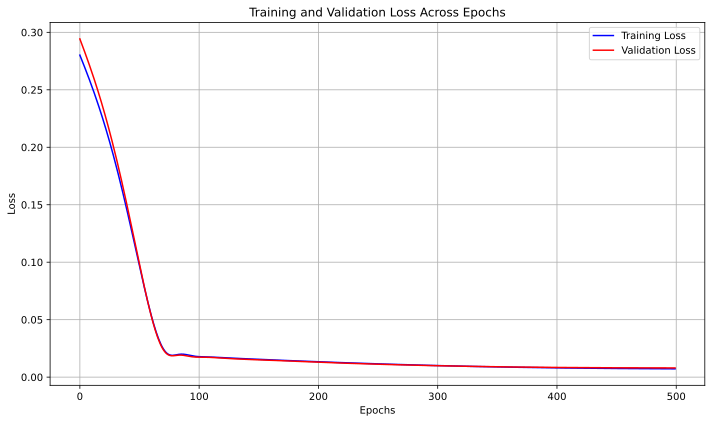

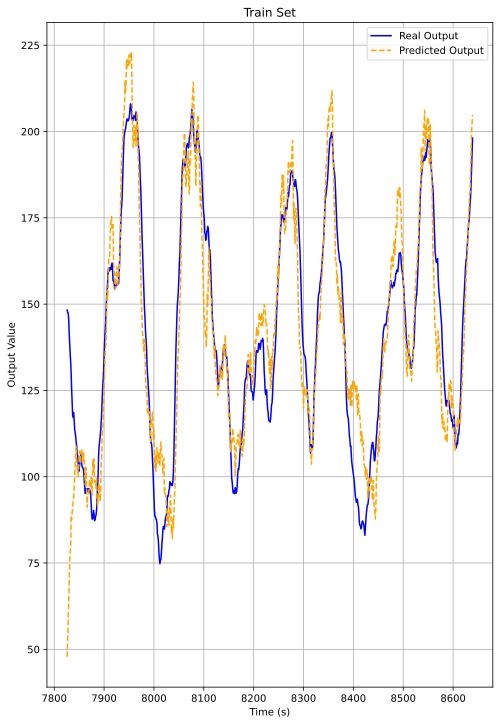

In [9]:
# --------------Plot identification results for G-----------------

#Training and Validation Loss Across Epochs
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), train_losses, label='Training Loss', color='blue')
plt.plot(range(epochs), val_losses, label='Validation Loss', color='red')  # Assuming val_losses are collected
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Across Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Model's Predictions vs Actual Output for the test set
fig, axes = plt.subplots(nrows=len(test_loader), ncols=1, figsize=(8, 12), sharex=True, sharey=True)
REN_0.to("cpu"); REN_1.to("cpu")

for u0_batch, _, _, u1_batch, y_batch, time in test_loader: # MH, I_rec (PID), R (noise + sat), I_sat (I_rec + R), CGM, time:
    
    u0_batch, u1_batch, y_batch= ensure_3d(u0_batch), ensure_3d(u1_batch), ensure_3d(y_batch)
    u0_batch, u1_batch, y_batch = u0_batch.to("cpu"), u1_batch.to("cpu"), y_batch.to("cpu")
    # Plot comparison between real and predicted for training set
    REN_0.eval(); REN_1.eval()

    y0_hat = REN_0(u0_batch)
    y1_hat = REN_1(u1_batch)# select the correct U
    y_hat = y0_hat - y1_hat
    
    y_batch_np = scaler_glucose.denormalize(y_batch.detach().cpu()).numpy()
    y_hat_np = scaler_glucose.denormalize(y_hat.detach().cpu()).numpy()
    


plt.plot(time, y_batch_np[0, :, 0], label="Real Output", color="blue")
plt.plot(time, y_hat_np[0, :, 0], label="Predicted Output", linestyle="--", color="orange")
plt.title(f"Train Set")
plt.xlabel("Time (s)")
plt.ylabel("Output Value")
plt.legend()
plt.grid(True)
plt.show()


In [10]:
#-----------------------------closedloop sysid of S through RENs------------------------
#--------------------------Define model for sysid---------------------------------------------
#create the REN model for S

y_init = x0


REN_0 = REN_IQC_gamma(dim_in= input_dim[0], dim_out= output_dim[0], dim_internal=dim_internal[0], dim_nl= dim_nl[0], y_init = y_init[0], QR_fun = set_QR, gammat=gamma[0], IQC_type = IQC_type[0], device=device)

REN_S = REN_IQC_gamma(dim_in= input_dim[1], dim_out= output_dim[1], dim_internal=dim_internal[1], dim_nl= dim_nl[1], y_init = y_init[1], QR_fun = set_QR, gammat=gamma[1], IQC_type = IQC_type[1], device=device)
Dual_REN = DualREN(REN_0, REN_S, device=device)
controller = NonLinearController(loaded_parameters, PID_functions, dataset.basal_vec, scaler_glucose, scaler_insulin, scaler_meal, use_noise)
closed_loop_REN = ClosedLoopSystem(Dual_REN, controller, negative=True)

closed_loop_closed_loop_1 = ClosedLoopSystem(closed_loop_REN, controller)



#--------------------------Define the loss function and optimizer---------------------------------------------
MSE = nn.MSELoss()
optimizer = torch.optim.Adam(Dual_REN.parameters(), lr=learning_rate)
optimizer.zero_grad()

In [11]:
#--------------------------5. Training---------------------------------------------------------------------


REN_0 = REN_0.to(device)
REN_S = REN_S.to(device)
Dual_Ren = Dual_REN.to(device)
controller = controller.to(device)
closed_loop_REN = closed_loop_REN.to(device)
x0 = x0.to(device)
print(f"[INFO] Training on device: {device}")

closed_loop_closed_loop_1 = closed_loop_closed_loop_1.to("cpu") # test always on cpu?
torch.set_default_dtype(torch.float32)  # default tensor dtype

train_losses = []
val_losses = []  # Store validation losses across epochs

for epoch in range(epochs):
    # ---------------- TRAINING ---------------- #
    closed_loop_REN.train()
    loss_epoch = 0.0  # Accumulate training loss


    for u0_batch, _, _, u1_batch, y_batch, _ in train_loader: # MH, I_rec (PID), R (noise + sat), I_sat (I_rec + R), CGM, time
        # u_batch.shape = batch_size   horizon   input_dim
        
        u0_batch, u1_batch, y_batch= ensure_3d(u0_batch), ensure_3d(u1_batch), ensure_3d(y_batch) # batch_size, time_horizon, input_dim
        u0_batch, u1_batch, y_batch = u0_batch.to(device), u1_batch.to(device), y_batch.to(device)
        u_batch = torch.cat((u0_batch, u1_batch), dim=2)  # concatenate along input dimension

        optimizer.zero_grad()
        
        Dual_REN.reset(); 
        # closed_loop_REN.reset() ?
        
        _, y_hat_train = closed_loop_REN(x0, u_batch)

        if torch.isnan(y_hat_train).any() or torch.isinf(y_hat_train).any():
            y_hat_train = torch.nan_to_num(y_hat_train, nan=1e5, posinf=1e5, neginf=-1e5)
            for name, param in closed_loop_REN.named_parameters():
                print(f"{name}: mean {param.data.mean()}, std {param.data.std()}")

        loss_batch = MSE(y_hat_train, y_batch)

        loss_batch.backward()

        optimizer.step()

        loss_epoch += loss_batch.item()

    loss_epoch /= len(train_loader)
    train_losses.append(loss_epoch)

    # ---------------- VALIDATION ---------------- #
    Dual_REN.eval()
    loss_val_epoch = 0.0

    with torch.no_grad():
        for u0_batch, _, _, u1_batch, y_batch, _ in val_loader: # MH, I_rec (PID), R (noise + sat), I_sat (I_rec + R), CGM, time
            # u_batch.shape = batch_size   horizon   input_dim
            
            u0_batch, u1_batch, y_batch= ensure_3d(u0_batch), ensure_3d(u1_batch), ensure_3d(y_batch) # batch_size, time_horizon, input_dim
            u_batch = torch.cat((u0_batch, u1_batch), dim=2)  # concatenate along input dimension
            u_batch, y_batch = u_batch.to(device), y_batch.to(device)
            
            Dual_REN.reset(); 

            _, y_hat_val = closed_loop_REN(x0, u_batch)
            
            loss_batch_val = MSE(y_hat_val, y_batch)

            loss_val_epoch += loss_batch_val.item()

    if epoch == 0 or loss_val_epoch < min_val_loss:
        min_val_loss = loss_val_epoch
        epoch_when_model_saved = epoch
        candidate_Dual_REN = Dual_REN

    loss_val_epoch /= len(val_loader)
    val_losses.append(loss_val_epoch)  # Store validation loss for plotting

    print(f"Epoch: {epoch + 1} \t||\t Training Loss: {loss_epoch:.6f} \t||\t Validation Loss: {loss_val_epoch:.6f}")

if redo_save:
    # model on CPU before saving
    candidate_Dual_REN_cpu = candidate_Dual_REN.to('cpu')

    # Save the best model
    # 1. Create models directory
    patient_str = "/paz_" + str(int(patient)).zfill(3)
    patient_model_folder = model_folder + "/"+ "strategy_2" + "/" + patient_str
    MODEL_PATH = Path(patient_model_folder)
    MODEL_PATH.mkdir(parents = True, exist_ok = True)
    # 2. save model state dict
    torch.save({
    'Dueal_REN_state_dict': candidate_Dual_REN_cpu.state_dict()}, MODEL_PATH / 'trained_models.pth')


    # save .mat
    np_x0 = x0.detach().cpu().numpy(); np_input_dim = np.array(input_dim); np_output_dim = np.array(output_dim); np_dim_internal =np.array(dim_internal); np_dim_nl = np.array(dim_nl)
    np_y_init = y_init.cpu().numpy(); np_gamma = gamma.cpu().numpy()
    
    # 4. Create params directory
    params_folder = Path(patient_model_folder) / "params"
    params_folder.mkdir(parents=True, exist_ok=True)
    scipy.io.savemat(params_folder / 'parameters.mat', {'train_losses': train_losses, 'val_losses': val_losses, 'epoch_when_model_saved': epoch_when_model_saved, 'x0': np_x0, 'input_dim': np_input_dim, 'output_dim': np_output_dim, 'dim_internal': np_dim_internal, 'dim_nl': np_dim_nl, 'y_init': np_y_init, 'gamma': np_gamma})

[INFO] Training on device: cpu


C:\Users\pogotar\Desktop\Dottorato\Nonlinear_system_identification_modified\Nonlinear_system_identification_diabetic_patients\env_non_lin_sys_id\Lib\site-packages\torch\utils\_device.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


Epoch: 1 	||	 Training Loss: 0.258073 	||	 Validation Loss: 0.269914


Epoch: 2 	||	 Training Loss: 0.255210 	||	 Validation Loss: 0.269853


Epoch: 3 	||	 Training Loss: 0.253388 	||	 Validation Loss: 0.266993


Epoch: 4 	||	 Training Loss: 0.250851 	||	 Validation Loss: 0.267022


Epoch: 5 	||	 Training Loss: 0.247597 	||	 Validation Loss: 0.259808


Epoch: 6 	||	 Training Loss: 0.245261 	||	 Validation Loss: 0.260282


Epoch: 7 	||	 Training Loss: 0.241987 	||	 Validation Loss: 0.252222


Epoch: 8 	||	 Training Loss: 0.239140 	||	 Validation Loss: 0.247998


Epoch: 9 	||	 Training Loss: 0.236530 	||	 Validation Loss: 0.248274


Epoch: 10 	||	 Training Loss: 0.233005 	||	 Validation Loss: 0.245569


Epoch: 11 	||	 Training Loss: 0.230219 	||	 Validation Loss: 0.245432


Epoch: 12 	||	 Training Loss: 0.225588 	||	 Validation Loss: 0.241430


Epoch: 13 	||	 Training Loss: 0.222886 	||	 Validation Loss: 0.237769


Epoch: 14 	||	 Training Loss: 0.220859 	||	 Validation Loss: 0.231466


Epoch: 15 	||	 Training Loss: 0.216425 	||	 Validation Loss: 0.228430


Epoch: 16 	||	 Training Loss: 0.211211 	||	 Validation Loss: 0.214429


Epoch: 17 	||	 Training Loss: 0.208267 	||	 Validation Loss: 0.217766


Epoch: 18 	||	 Training Loss: 0.204342 	||	 Validation Loss: 0.215772


Epoch: 19 	||	 Training Loss: 0.199760 	||	 Validation Loss: 0.207146


Epoch: 20 	||	 Training Loss: 0.196580 	||	 Validation Loss: 0.201584


Epoch: 21 	||	 Training Loss: 0.192928 	||	 Validation Loss: 0.201960


Epoch: 22 	||	 Training Loss: 0.188597 	||	 Validation Loss: 0.200188


Epoch: 23 	||	 Training Loss: 0.185072 	||	 Validation Loss: 0.193155


Epoch: 24 	||	 Training Loss: 0.181656 	||	 Validation Loss: 0.191924


Epoch: 25 	||	 Training Loss: 0.176384 	||	 Validation Loss: 0.188973


Epoch: 26 	||	 Training Loss: 0.172297 	||	 Validation Loss: 0.180608


Epoch: 27 	||	 Training Loss: 0.169967 	||	 Validation Loss: 0.174222


Epoch: 28 	||	 Training Loss: 0.163486 	||	 Validation Loss: 0.174311


Epoch: 29 	||	 Training Loss: 0.163008 	||	 Validation Loss: 0.175826


Epoch: 30 	||	 Training Loss: 0.158741 	||	 Validation Loss: 0.161508


Epoch: 31 	||	 Training Loss: 0.154854 	||	 Validation Loss: 0.160747


Epoch: 32 	||	 Training Loss: 0.152727 	||	 Validation Loss: 0.166524


Epoch: 33 	||	 Training Loss: 0.147066 	||	 Validation Loss: 0.148373


Epoch: 34 	||	 Training Loss: 0.144764 	||	 Validation Loss: 0.160891


Epoch: 35 	||	 Training Loss: 0.142974 	||	 Validation Loss: 0.157852


Epoch: 36 	||	 Training Loss: 0.139809 	||	 Validation Loss: 0.147258


Epoch: 37 	||	 Training Loss: 0.135716 	||	 Validation Loss: 0.145238


Epoch: 38 	||	 Training Loss: 0.134268 	||	 Validation Loss: 0.140399


Epoch: 39 	||	 Training Loss: 0.129010 	||	 Validation Loss: 0.145027


Epoch: 40 	||	 Training Loss: 0.127340 	||	 Validation Loss: 0.133705


Epoch: 41 	||	 Training Loss: 0.125449 	||	 Validation Loss: 0.139039


Epoch: 42 	||	 Training Loss: 0.120215 	||	 Validation Loss: 0.132280


Epoch: 43 	||	 Training Loss: 0.115384 	||	 Validation Loss: 0.130349


Epoch: 44 	||	 Training Loss: 0.113995 	||	 Validation Loss: 0.122580


Epoch: 45 	||	 Training Loss: 0.110141 	||	 Validation Loss: 0.116471


Epoch: 46 	||	 Training Loss: 0.107021 	||	 Validation Loss: 0.122934


Epoch: 47 	||	 Training Loss: 0.104254 	||	 Validation Loss: 0.116897


Epoch: 48 	||	 Training Loss: 0.100592 	||	 Validation Loss: 0.108015


Epoch: 49 	||	 Training Loss: 0.096268 	||	 Validation Loss: 0.102016


Epoch: 50 	||	 Training Loss: 0.094665 	||	 Validation Loss: 0.102161


Epoch: 51 	||	 Training Loss: 0.091600 	||	 Validation Loss: 0.095236


Epoch: 52 	||	 Training Loss: 0.087855 	||	 Validation Loss: 0.096209


Epoch: 53 	||	 Training Loss: 0.086345 	||	 Validation Loss: 0.091372


Epoch: 54 	||	 Training Loss: 0.081976 	||	 Validation Loss: 0.088003


Epoch: 55 	||	 Training Loss: 0.078504 	||	 Validation Loss: 0.082639


Epoch: 56 	||	 Training Loss: 0.078539 	||	 Validation Loss: 0.080538


Epoch: 57 	||	 Training Loss: 0.076274 	||	 Validation Loss: 0.074219


Epoch: 58 	||	 Training Loss: 0.072565 	||	 Validation Loss: 0.075940


Epoch: 59 	||	 Training Loss: 0.069915 	||	 Validation Loss: 0.075194


Epoch: 60 	||	 Training Loss: 0.069470 	||	 Validation Loss: 0.072003


Epoch: 61 	||	 Training Loss: 0.067004 	||	 Validation Loss: 0.069135


Epoch: 62 	||	 Training Loss: 0.066450 	||	 Validation Loss: 0.067084


Epoch: 63 	||	 Training Loss: 0.062817 	||	 Validation Loss: 0.066012


Epoch: 64 	||	 Training Loss: 0.062251 	||	 Validation Loss: 0.064134


Epoch: 65 	||	 Training Loss: 0.061590 	||	 Validation Loss: 0.064133


Epoch: 66 	||	 Training Loss: 0.059352 	||	 Validation Loss: 0.061235


Epoch: 67 	||	 Training Loss: 0.057966 	||	 Validation Loss: 0.060064


Epoch: 68 	||	 Training Loss: 0.056787 	||	 Validation Loss: 0.059571


Epoch: 69 	||	 Training Loss: 0.055837 	||	 Validation Loss: 0.055174


Epoch: 70 	||	 Training Loss: 0.055380 	||	 Validation Loss: 0.054184


Epoch: 71 	||	 Training Loss: 0.053515 	||	 Validation Loss: 0.053503


Epoch: 72 	||	 Training Loss: 0.052872 	||	 Validation Loss: 0.051766


Epoch: 73 	||	 Training Loss: 0.051802 	||	 Validation Loss: 0.050147


Epoch: 74 	||	 Training Loss: 0.050139 	||	 Validation Loss: 0.049259


Epoch: 75 	||	 Training Loss: 0.049377 	||	 Validation Loss: 0.049549


Epoch: 76 	||	 Training Loss: 0.048106 	||	 Validation Loss: 0.047878


Epoch: 77 	||	 Training Loss: 0.047357 	||	 Validation Loss: 0.045798


Epoch: 78 	||	 Training Loss: 0.046753 	||	 Validation Loss: 0.045624


Epoch: 79 	||	 Training Loss: 0.045204 	||	 Validation Loss: 0.043697


Epoch: 80 	||	 Training Loss: 0.044067 	||	 Validation Loss: 0.042485


Epoch: 81 	||	 Training Loss: 0.042757 	||	 Validation Loss: 0.042796


Epoch: 82 	||	 Training Loss: 0.042038 	||	 Validation Loss: 0.041179


Epoch: 83 	||	 Training Loss: 0.041494 	||	 Validation Loss: 0.039644


Epoch: 84 	||	 Training Loss: 0.039871 	||	 Validation Loss: 0.039428


Epoch: 85 	||	 Training Loss: 0.039252 	||	 Validation Loss: 0.038354


Epoch: 86 	||	 Training Loss: 0.038145 	||	 Validation Loss: 0.036867


Epoch: 87 	||	 Training Loss: 0.037041 	||	 Validation Loss: 0.035806


Epoch: 88 	||	 Training Loss: 0.035995 	||	 Validation Loss: 0.034662


Epoch: 89 	||	 Training Loss: 0.035292 	||	 Validation Loss: 0.033656


Epoch: 90 	||	 Training Loss: 0.034312 	||	 Validation Loss: 0.032394


Epoch: 91 	||	 Training Loss: 0.033338 	||	 Validation Loss: 0.031334


Epoch: 92 	||	 Training Loss: 0.032399 	||	 Validation Loss: 0.030692


Epoch: 93 	||	 Training Loss: 0.031760 	||	 Validation Loss: 0.029913


Epoch: 94 	||	 Training Loss: 0.030925 	||	 Validation Loss: 0.028658


Epoch: 95 	||	 Training Loss: 0.030089 	||	 Validation Loss: 0.027457


Epoch: 96 	||	 Training Loss: 0.029007 	||	 Validation Loss: 0.026731


Epoch: 97 	||	 Training Loss: 0.027802 	||	 Validation Loss: 0.026031


Epoch: 98 	||	 Training Loss: 0.027301 	||	 Validation Loss: 0.025368


Epoch: 99 	||	 Training Loss: 0.026376 	||	 Validation Loss: 0.024317


Epoch: 100 	||	 Training Loss: 0.025739 	||	 Validation Loss: 0.023712


Epoch: 101 	||	 Training Loss: 0.024847 	||	 Validation Loss: 0.023268


Epoch: 102 	||	 Training Loss: 0.024245 	||	 Validation Loss: 0.022391


Epoch: 103 	||	 Training Loss: 0.023464 	||	 Validation Loss: 0.022019


Epoch: 104 	||	 Training Loss: 0.022875 	||	 Validation Loss: 0.020966


Epoch: 105 	||	 Training Loss: 0.021960 	||	 Validation Loss: 0.020587


Epoch: 106 	||	 Training Loss: 0.021324 	||	 Validation Loss: 0.020024


Epoch: 107 	||	 Training Loss: 0.020607 	||	 Validation Loss: 0.019586


Epoch: 108 	||	 Training Loss: 0.020061 	||	 Validation Loss: 0.018960


Epoch: 109 	||	 Training Loss: 0.019409 	||	 Validation Loss: 0.018423


Epoch: 110 	||	 Training Loss: 0.019016 	||	 Validation Loss: 0.017792


Epoch: 111 	||	 Training Loss: 0.018457 	||	 Validation Loss: 0.017390


Epoch: 112 	||	 Training Loss: 0.017943 	||	 Validation Loss: 0.016983


Epoch: 113 	||	 Training Loss: 0.017396 	||	 Validation Loss: 0.016416


Epoch: 114 	||	 Training Loss: 0.017017 	||	 Validation Loss: 0.016040


Epoch: 115 	||	 Training Loss: 0.016545 	||	 Validation Loss: 0.015707


Epoch: 116 	||	 Training Loss: 0.016072 	||	 Validation Loss: 0.015243


Epoch: 117 	||	 Training Loss: 0.015694 	||	 Validation Loss: 0.014834


Epoch: 118 	||	 Training Loss: 0.015343 	||	 Validation Loss: 0.014584


Epoch: 119 	||	 Training Loss: 0.014923 	||	 Validation Loss: 0.014336


Epoch: 120 	||	 Training Loss: 0.014553 	||	 Validation Loss: 0.013956


Epoch: 121 	||	 Training Loss: 0.014207 	||	 Validation Loss: 0.013712


Epoch: 122 	||	 Training Loss: 0.013933 	||	 Validation Loss: 0.013424


Epoch: 123 	||	 Training Loss: 0.013590 	||	 Validation Loss: 0.013260


Epoch: 124 	||	 Training Loss: 0.013297 	||	 Validation Loss: 0.013012


Epoch: 125 	||	 Training Loss: 0.013030 	||	 Validation Loss: 0.012808


Epoch: 126 	||	 Training Loss: 0.012783 	||	 Validation Loss: 0.012555


Epoch: 127 	||	 Training Loss: 0.012595 	||	 Validation Loss: 0.012370


Epoch: 128 	||	 Training Loss: 0.012311 	||	 Validation Loss: 0.012083


Epoch: 129 	||	 Training Loss: 0.012089 	||	 Validation Loss: 0.011968


Epoch: 130 	||	 Training Loss: 0.011870 	||	 Validation Loss: 0.011781


Epoch: 131 	||	 Training Loss: 0.011669 	||	 Validation Loss: 0.011601


Epoch: 132 	||	 Training Loss: 0.011482 	||	 Validation Loss: 0.011455


Epoch: 133 	||	 Training Loss: 0.011292 	||	 Validation Loss: 0.011289


Epoch: 134 	||	 Training Loss: 0.011109 	||	 Validation Loss: 0.011183


Epoch: 135 	||	 Training Loss: 0.010928 	||	 Validation Loss: 0.011009


Epoch: 136 	||	 Training Loss: 0.010786 	||	 Validation Loss: 0.010935


Epoch: 137 	||	 Training Loss: 0.010671 	||	 Validation Loss: 0.010765


Epoch: 138 	||	 Training Loss: 0.010493 	||	 Validation Loss: 0.010713


Epoch: 139 	||	 Training Loss: 0.010370 	||	 Validation Loss: 0.010618


Epoch: 140 	||	 Training Loss: 0.010236 	||	 Validation Loss: 0.010515


Epoch: 141 	||	 Training Loss: 0.010117 	||	 Validation Loss: 0.010416


Epoch: 142 	||	 Training Loss: 0.010002 	||	 Validation Loss: 0.010346


Epoch: 143 	||	 Training Loss: 0.009898 	||	 Validation Loss: 0.010254


Epoch: 144 	||	 Training Loss: 0.009788 	||	 Validation Loss: 0.010220


Epoch: 145 	||	 Training Loss: 0.009709 	||	 Validation Loss: 0.010142


Epoch: 146 	||	 Training Loss: 0.009597 	||	 Validation Loss: 0.010075


Epoch: 147 	||	 Training Loss: 0.009505 	||	 Validation Loss: 0.010017


Epoch: 148 	||	 Training Loss: 0.009434 	||	 Validation Loss: 0.009961


Epoch: 149 	||	 Training Loss: 0.009346 	||	 Validation Loss: 0.009918


Epoch: 150 	||	 Training Loss: 0.009259 	||	 Validation Loss: 0.009845


Epoch: 151 	||	 Training Loss: 0.009184 	||	 Validation Loss: 0.009804


Epoch: 152 	||	 Training Loss: 0.009116 	||	 Validation Loss: 0.009737


Epoch: 153 	||	 Training Loss: 0.009045 	||	 Validation Loss: 0.009689


Epoch: 154 	||	 Training Loss: 0.008992 	||	 Validation Loss: 0.009663


Epoch: 155 	||	 Training Loss: 0.008926 	||	 Validation Loss: 0.009597


Epoch: 156 	||	 Training Loss: 0.008859 	||	 Validation Loss: 0.009571


Epoch: 157 	||	 Training Loss: 0.008812 	||	 Validation Loss: 0.009521


Epoch: 158 	||	 Training Loss: 0.008751 	||	 Validation Loss: 0.009495


Epoch: 159 	||	 Training Loss: 0.008698 	||	 Validation Loss: 0.009450


Epoch: 160 	||	 Training Loss: 0.008641 	||	 Validation Loss: 0.009427


Epoch: 161 	||	 Training Loss: 0.008591 	||	 Validation Loss: 0.009390


Epoch: 162 	||	 Training Loss: 0.008550 	||	 Validation Loss: 0.009377


Epoch: 163 	||	 Training Loss: 0.008502 	||	 Validation Loss: 0.009324


Epoch: 164 	||	 Training Loss: 0.008451 	||	 Validation Loss: 0.009306


Epoch: 165 	||	 Training Loss: 0.008410 	||	 Validation Loss: 0.009271


Epoch: 166 	||	 Training Loss: 0.008373 	||	 Validation Loss: 0.009242


Epoch: 167 	||	 Training Loss: 0.008329 	||	 Validation Loss: 0.009222


Epoch: 168 	||	 Training Loss: 0.008293 	||	 Validation Loss: 0.009193


Epoch: 169 	||	 Training Loss: 0.008252 	||	 Validation Loss: 0.009174


Epoch: 170 	||	 Training Loss: 0.008214 	||	 Validation Loss: 0.009141


Epoch: 171 	||	 Training Loss: 0.008183 	||	 Validation Loss: 0.009126


Epoch: 172 	||	 Training Loss: 0.008146 	||	 Validation Loss: 0.009094


Epoch: 173 	||	 Training Loss: 0.008114 	||	 Validation Loss: 0.009077


Epoch: 174 	||	 Training Loss: 0.008086 	||	 Validation Loss: 0.009058


Epoch: 175 	||	 Training Loss: 0.008054 	||	 Validation Loss: 0.009039


Epoch: 176 	||	 Training Loss: 0.008020 	||	 Validation Loss: 0.009021


Epoch: 177 	||	 Training Loss: 0.007993 	||	 Validation Loss: 0.009002


Epoch: 178 	||	 Training Loss: 0.007969 	||	 Validation Loss: 0.008975


Epoch: 179 	||	 Training Loss: 0.007938 	||	 Validation Loss: 0.008951


Epoch: 180 	||	 Training Loss: 0.007911 	||	 Validation Loss: 0.008943


Epoch: 181 	||	 Training Loss: 0.007887 	||	 Validation Loss: 0.008921


Epoch: 182 	||	 Training Loss: 0.007862 	||	 Validation Loss: 0.008904


Epoch: 183 	||	 Training Loss: 0.007836 	||	 Validation Loss: 0.008881


Epoch: 184 	||	 Training Loss: 0.007812 	||	 Validation Loss: 0.008871


Epoch: 185 	||	 Training Loss: 0.007792 	||	 Validation Loss: 0.008854


Epoch: 186 	||	 Training Loss: 0.007769 	||	 Validation Loss: 0.008844


Epoch: 187 	||	 Training Loss: 0.007749 	||	 Validation Loss: 0.008828


Epoch: 188 	||	 Training Loss: 0.007730 	||	 Validation Loss: 0.008810


Epoch: 189 	||	 Training Loss: 0.007711 	||	 Validation Loss: 0.008803


Epoch: 190 	||	 Training Loss: 0.007691 	||	 Validation Loss: 0.008780


Epoch: 191 	||	 Training Loss: 0.007673 	||	 Validation Loss: 0.008776


Epoch: 192 	||	 Training Loss: 0.007652 	||	 Validation Loss: 0.008757


Epoch: 193 	||	 Training Loss: 0.007637 	||	 Validation Loss: 0.008751


Epoch: 194 	||	 Training Loss: 0.007621 	||	 Validation Loss: 0.008737


Epoch: 195 	||	 Training Loss: 0.007603 	||	 Validation Loss: 0.008727


Epoch: 196 	||	 Training Loss: 0.007587 	||	 Validation Loss: 0.008715


Epoch: 197 	||	 Training Loss: 0.007572 	||	 Validation Loss: 0.008701


Epoch: 198 	||	 Training Loss: 0.007557 	||	 Validation Loss: 0.008689


Epoch: 199 	||	 Training Loss: 0.007543 	||	 Validation Loss: 0.008680


Epoch: 200 	||	 Training Loss: 0.007529 	||	 Validation Loss: 0.008673


Epoch: 201 	||	 Training Loss: 0.007514 	||	 Validation Loss: 0.008668


Epoch: 202 	||	 Training Loss: 0.007502 	||	 Validation Loss: 0.008656


Epoch: 203 	||	 Training Loss: 0.007488 	||	 Validation Loss: 0.008644


Epoch: 204 	||	 Training Loss: 0.007476 	||	 Validation Loss: 0.008633


Epoch: 205 	||	 Training Loss: 0.007465 	||	 Validation Loss: 0.008630


Epoch: 206 	||	 Training Loss: 0.007452 	||	 Validation Loss: 0.008618


Epoch: 207 	||	 Training Loss: 0.007439 	||	 Validation Loss: 0.008611


Epoch: 208 	||	 Training Loss: 0.007429 	||	 Validation Loss: 0.008599


Epoch: 209 	||	 Training Loss: 0.007417 	||	 Validation Loss: 0.008599


Epoch: 210 	||	 Training Loss: 0.007407 	||	 Validation Loss: 0.008585


Epoch: 211 	||	 Training Loss: 0.007397 	||	 Validation Loss: 0.008577


Epoch: 212 	||	 Training Loss: 0.007390 	||	 Validation Loss: 0.008573


Epoch: 213 	||	 Training Loss: 0.007376 	||	 Validation Loss: 0.008567


Epoch: 214 	||	 Training Loss: 0.007368 	||	 Validation Loss: 0.008560


Epoch: 215 	||	 Training Loss: 0.007356 	||	 Validation Loss: 0.008548


Epoch: 216 	||	 Training Loss: 0.007349 	||	 Validation Loss: 0.008544


Epoch: 217 	||	 Training Loss: 0.007340 	||	 Validation Loss: 0.008535


Epoch: 218 	||	 Training Loss: 0.007332 	||	 Validation Loss: 0.008532


Epoch: 219 	||	 Training Loss: 0.007324 	||	 Validation Loss: 0.008521


Epoch: 220 	||	 Training Loss: 0.007315 	||	 Validation Loss: 0.008515


Epoch: 221 	||	 Training Loss: 0.007307 	||	 Validation Loss: 0.008512


Epoch: 222 	||	 Training Loss: 0.007299 	||	 Validation Loss: 0.008507


Epoch: 223 	||	 Training Loss: 0.007291 	||	 Validation Loss: 0.008502


Epoch: 224 	||	 Training Loss: 0.007284 	||	 Validation Loss: 0.008498


Epoch: 225 	||	 Training Loss: 0.007277 	||	 Validation Loss: 0.008491


Epoch: 226 	||	 Training Loss: 0.007268 	||	 Validation Loss: 0.008485


Epoch: 227 	||	 Training Loss: 0.007264 	||	 Validation Loss: 0.008478


Epoch: 228 	||	 Training Loss: 0.007258 	||	 Validation Loss: 0.008475


Epoch: 229 	||	 Training Loss: 0.007248 	||	 Validation Loss: 0.008470


Epoch: 230 	||	 Training Loss: 0.007242 	||	 Validation Loss: 0.008463


Epoch: 231 	||	 Training Loss: 0.007235 	||	 Validation Loss: 0.008459


Epoch: 232 	||	 Training Loss: 0.007228 	||	 Validation Loss: 0.008459


Epoch: 233 	||	 Training Loss: 0.007223 	||	 Validation Loss: 0.008451


Epoch: 234 	||	 Training Loss: 0.007217 	||	 Validation Loss: 0.008447


Epoch: 235 	||	 Training Loss: 0.007212 	||	 Validation Loss: 0.008444


Epoch: 236 	||	 Training Loss: 0.007206 	||	 Validation Loss: 0.008435


Epoch: 237 	||	 Training Loss: 0.007200 	||	 Validation Loss: 0.008430


Epoch: 238 	||	 Training Loss: 0.007195 	||	 Validation Loss: 0.008425


Epoch: 239 	||	 Training Loss: 0.007188 	||	 Validation Loss: 0.008424


Epoch: 240 	||	 Training Loss: 0.007183 	||	 Validation Loss: 0.008419


Epoch: 241 	||	 Training Loss: 0.007178 	||	 Validation Loss: 0.008413


Epoch: 242 	||	 Training Loss: 0.007174 	||	 Validation Loss: 0.008416


Epoch: 243 	||	 Training Loss: 0.007167 	||	 Validation Loss: 0.008410


Epoch: 244 	||	 Training Loss: 0.007164 	||	 Validation Loss: 0.008410


Epoch: 245 	||	 Training Loss: 0.007159 	||	 Validation Loss: 0.008401


Epoch: 246 	||	 Training Loss: 0.007156 	||	 Validation Loss: 0.008398


Epoch: 247 	||	 Training Loss: 0.007150 	||	 Validation Loss: 0.008395


Epoch: 248 	||	 Training Loss: 0.007146 	||	 Validation Loss: 0.008390


Epoch: 249 	||	 Training Loss: 0.007142 	||	 Validation Loss: 0.008389


Epoch: 250 	||	 Training Loss: 0.007138 	||	 Validation Loss: 0.008387


Epoch: 251 	||	 Training Loss: 0.007133 	||	 Validation Loss: 0.008379


Epoch: 252 	||	 Training Loss: 0.007132 	||	 Validation Loss: 0.008378


Epoch: 253 	||	 Training Loss: 0.007124 	||	 Validation Loss: 0.008375


Epoch: 254 	||	 Training Loss: 0.007121 	||	 Validation Loss: 0.008369


Epoch: 255 	||	 Training Loss: 0.007116 	||	 Validation Loss: 0.008367


Epoch: 256 	||	 Training Loss: 0.007113 	||	 Validation Loss: 0.008366


Epoch: 257 	||	 Training Loss: 0.007109 	||	 Validation Loss: 0.008368


Epoch: 258 	||	 Training Loss: 0.007106 	||	 Validation Loss: 0.008359


Epoch: 259 	||	 Training Loss: 0.007101 	||	 Validation Loss: 0.008355


Epoch: 260 	||	 Training Loss: 0.007097 	||	 Validation Loss: 0.008351


Epoch: 261 	||	 Training Loss: 0.007095 	||	 Validation Loss: 0.008347


Epoch: 262 	||	 Training Loss: 0.007089 	||	 Validation Loss: 0.008347


Epoch: 263 	||	 Training Loss: 0.007088 	||	 Validation Loss: 0.008344


Epoch: 264 	||	 Training Loss: 0.007085 	||	 Validation Loss: 0.008342


Epoch: 265 	||	 Training Loss: 0.007082 	||	 Validation Loss: 0.008336


Epoch: 266 	||	 Training Loss: 0.007080 	||	 Validation Loss: 0.008334


Epoch: 267 	||	 Training Loss: 0.007076 	||	 Validation Loss: 0.008331


Epoch: 268 	||	 Training Loss: 0.007073 	||	 Validation Loss: 0.008329


Epoch: 269 	||	 Training Loss: 0.007070 	||	 Validation Loss: 0.008327


Epoch: 270 	||	 Training Loss: 0.007066 	||	 Validation Loss: 0.008322


Epoch: 271 	||	 Training Loss: 0.007065 	||	 Validation Loss: 0.008325


Epoch: 272 	||	 Training Loss: 0.007060 	||	 Validation Loss: 0.008317


Epoch: 273 	||	 Training Loss: 0.007058 	||	 Validation Loss: 0.008320


Epoch: 274 	||	 Training Loss: 0.007055 	||	 Validation Loss: 0.008313


Epoch: 275 	||	 Training Loss: 0.007052 	||	 Validation Loss: 0.008311


Epoch: 276 	||	 Training Loss: 0.007048 	||	 Validation Loss: 0.008310


Epoch: 277 	||	 Training Loss: 0.007046 	||	 Validation Loss: 0.008305


Epoch: 278 	||	 Training Loss: 0.007043 	||	 Validation Loss: 0.008304


Epoch: 279 	||	 Training Loss: 0.007041 	||	 Validation Loss: 0.008301


Epoch: 280 	||	 Training Loss: 0.007037 	||	 Validation Loss: 0.008298


Epoch: 281 	||	 Training Loss: 0.007035 	||	 Validation Loss: 0.008298


Epoch: 282 	||	 Training Loss: 0.007033 	||	 Validation Loss: 0.008293


Epoch: 283 	||	 Training Loss: 0.007031 	||	 Validation Loss: 0.008294


Epoch: 284 	||	 Training Loss: 0.007027 	||	 Validation Loss: 0.008290


Epoch: 285 	||	 Training Loss: 0.007023 	||	 Validation Loss: 0.008285


Epoch: 286 	||	 Training Loss: 0.007021 	||	 Validation Loss: 0.008286


Epoch: 287 	||	 Training Loss: 0.007019 	||	 Validation Loss: 0.008285


Epoch: 288 	||	 Training Loss: 0.007018 	||	 Validation Loss: 0.008280


Epoch: 289 	||	 Training Loss: 0.007013 	||	 Validation Loss: 0.008283


Epoch: 290 	||	 Training Loss: 0.007011 	||	 Validation Loss: 0.008281


Epoch: 291 	||	 Training Loss: 0.007009 	||	 Validation Loss: 0.008277


Epoch: 292 	||	 Training Loss: 0.007009 	||	 Validation Loss: 0.008271


Epoch: 293 	||	 Training Loss: 0.007005 	||	 Validation Loss: 0.008269


Epoch: 294 	||	 Training Loss: 0.007002 	||	 Validation Loss: 0.008261


Epoch: 295 	||	 Training Loss: 0.007000 	||	 Validation Loss: 0.008268


Epoch: 296 	||	 Training Loss: 0.007000 	||	 Validation Loss: 0.008270


Epoch: 297 	||	 Training Loss: 0.006998 	||	 Validation Loss: 0.008263


Epoch: 298 	||	 Training Loss: 0.006998 	||	 Validation Loss: 0.008261


Epoch: 299 	||	 Training Loss: 0.006992 	||	 Validation Loss: 0.008261


Epoch: 300 	||	 Training Loss: 0.006992 	||	 Validation Loss: 0.008260


Epoch: 301 	||	 Training Loss: 0.006989 	||	 Validation Loss: 0.008257


Epoch: 302 	||	 Training Loss: 0.006985 	||	 Validation Loss: 0.008255


Epoch: 303 	||	 Training Loss: 0.006983 	||	 Validation Loss: 0.008250


Epoch: 304 	||	 Training Loss: 0.006982 	||	 Validation Loss: 0.008248


Epoch: 305 	||	 Training Loss: 0.006980 	||	 Validation Loss: 0.008245


Epoch: 306 	||	 Training Loss: 0.006978 	||	 Validation Loss: 0.008246


Epoch: 307 	||	 Training Loss: 0.006976 	||	 Validation Loss: 0.008238


Epoch: 308 	||	 Training Loss: 0.006974 	||	 Validation Loss: 0.008239


Epoch: 309 	||	 Training Loss: 0.006971 	||	 Validation Loss: 0.008240


Epoch: 310 	||	 Training Loss: 0.006969 	||	 Validation Loss: 0.008237


Epoch: 311 	||	 Training Loss: 0.006967 	||	 Validation Loss: 0.008232


Epoch: 312 	||	 Training Loss: 0.006966 	||	 Validation Loss: 0.008236


Epoch: 313 	||	 Training Loss: 0.006964 	||	 Validation Loss: 0.008233


Epoch: 314 	||	 Training Loss: 0.006964 	||	 Validation Loss: 0.008233


Epoch: 315 	||	 Training Loss: 0.006962 	||	 Validation Loss: 0.008233


Epoch: 316 	||	 Training Loss: 0.006959 	||	 Validation Loss: 0.008227


Epoch: 317 	||	 Training Loss: 0.006957 	||	 Validation Loss: 0.008224


Epoch: 318 	||	 Training Loss: 0.006955 	||	 Validation Loss: 0.008226


Epoch: 319 	||	 Training Loss: 0.006954 	||	 Validation Loss: 0.008219


Epoch: 320 	||	 Training Loss: 0.006953 	||	 Validation Loss: 0.008221


Epoch: 321 	||	 Training Loss: 0.006950 	||	 Validation Loss: 0.008215


Epoch: 322 	||	 Training Loss: 0.006950 	||	 Validation Loss: 0.008215


Epoch: 323 	||	 Training Loss: 0.006946 	||	 Validation Loss: 0.008210


Epoch: 324 	||	 Training Loss: 0.006947 	||	 Validation Loss: 0.008209


Epoch: 325 	||	 Training Loss: 0.006943 	||	 Validation Loss: 0.008207


Epoch: 326 	||	 Training Loss: 0.006943 	||	 Validation Loss: 0.008207


Epoch: 327 	||	 Training Loss: 0.006941 	||	 Validation Loss: 0.008207


Epoch: 328 	||	 Training Loss: 0.006940 	||	 Validation Loss: 0.008207


Epoch: 329 	||	 Training Loss: 0.006939 	||	 Validation Loss: 0.008203


Epoch: 330 	||	 Training Loss: 0.006934 	||	 Validation Loss: 0.008203


Epoch: 331 	||	 Training Loss: 0.006935 	||	 Validation Loss: 0.008207


Epoch: 332 	||	 Training Loss: 0.006932 	||	 Validation Loss: 0.008205


Epoch: 333 	||	 Training Loss: 0.006931 	||	 Validation Loss: 0.008203


Epoch: 334 	||	 Training Loss: 0.006929 	||	 Validation Loss: 0.008207


Epoch: 335 	||	 Training Loss: 0.006927 	||	 Validation Loss: 0.008201


Epoch: 336 	||	 Training Loss: 0.006926 	||	 Validation Loss: 0.008204


Epoch: 337 	||	 Training Loss: 0.006925 	||	 Validation Loss: 0.008201


Epoch: 338 	||	 Training Loss: 0.006924 	||	 Validation Loss: 0.008198


Epoch: 339 	||	 Training Loss: 0.006921 	||	 Validation Loss: 0.008191


Epoch: 340 	||	 Training Loss: 0.006920 	||	 Validation Loss: 0.008189


Epoch: 341 	||	 Training Loss: 0.006918 	||	 Validation Loss: 0.008189


Epoch: 342 	||	 Training Loss: 0.006916 	||	 Validation Loss: 0.008192


Epoch: 343 	||	 Training Loss: 0.006915 	||	 Validation Loss: 0.008185


Epoch: 344 	||	 Training Loss: 0.006912 	||	 Validation Loss: 0.008182


Epoch: 345 	||	 Training Loss: 0.006912 	||	 Validation Loss: 0.008179


Epoch: 346 	||	 Training Loss: 0.006910 	||	 Validation Loss: 0.008179


Epoch: 347 	||	 Training Loss: 0.006909 	||	 Validation Loss: 0.008178


Epoch: 348 	||	 Training Loss: 0.006909 	||	 Validation Loss: 0.008178


Epoch: 349 	||	 Training Loss: 0.006904 	||	 Validation Loss: 0.008176


Epoch: 350 	||	 Training Loss: 0.006903 	||	 Validation Loss: 0.008180


Epoch: 351 	||	 Training Loss: 0.006901 	||	 Validation Loss: 0.008172


Epoch: 352 	||	 Training Loss: 0.006901 	||	 Validation Loss: 0.008171


Epoch: 353 	||	 Training Loss: 0.006899 	||	 Validation Loss: 0.008169


Epoch: 354 	||	 Training Loss: 0.006900 	||	 Validation Loss: 0.008170


Epoch: 355 	||	 Training Loss: 0.006897 	||	 Validation Loss: 0.008170


Epoch: 356 	||	 Training Loss: 0.006896 	||	 Validation Loss: 0.008170


Epoch: 357 	||	 Training Loss: 0.006892 	||	 Validation Loss: 0.008165


Epoch: 358 	||	 Training Loss: 0.006893 	||	 Validation Loss: 0.008169


Epoch: 359 	||	 Training Loss: 0.006890 	||	 Validation Loss: 0.008165


Epoch: 360 	||	 Training Loss: 0.006890 	||	 Validation Loss: 0.008162


Epoch: 361 	||	 Training Loss: 0.006888 	||	 Validation Loss: 0.008161


Epoch: 362 	||	 Training Loss: 0.006887 	||	 Validation Loss: 0.008160


Epoch: 363 	||	 Training Loss: 0.006885 	||	 Validation Loss: 0.008161


Epoch: 364 	||	 Training Loss: 0.006883 	||	 Validation Loss: 0.008158


Epoch: 365 	||	 Training Loss: 0.006882 	||	 Validation Loss: 0.008152


Epoch: 366 	||	 Training Loss: 0.006881 	||	 Validation Loss: 0.008149


Epoch: 367 	||	 Training Loss: 0.006880 	||	 Validation Loss: 0.008159


Epoch: 368 	||	 Training Loss: 0.006877 	||	 Validation Loss: 0.008159


Epoch: 369 	||	 Training Loss: 0.006877 	||	 Validation Loss: 0.008148


Epoch: 370 	||	 Training Loss: 0.006876 	||	 Validation Loss: 0.008149


Epoch: 371 	||	 Training Loss: 0.006876 	||	 Validation Loss: 0.008145


Epoch: 372 	||	 Training Loss: 0.006876 	||	 Validation Loss: 0.008145


Epoch: 373 	||	 Training Loss: 0.006872 	||	 Validation Loss: 0.008146


Epoch: 374 	||	 Training Loss: 0.006870 	||	 Validation Loss: 0.008143


Epoch: 375 	||	 Training Loss: 0.006870 	||	 Validation Loss: 0.008142


Epoch: 376 	||	 Training Loss: 0.006869 	||	 Validation Loss: 0.008136


Epoch: 377 	||	 Training Loss: 0.006867 	||	 Validation Loss: 0.008134


Epoch: 378 	||	 Training Loss: 0.006865 	||	 Validation Loss: 0.008134


Epoch: 379 	||	 Training Loss: 0.006864 	||	 Validation Loss: 0.008143


Epoch: 380 	||	 Training Loss: 0.006865 	||	 Validation Loss: 0.008140


Epoch: 381 	||	 Training Loss: 0.006861 	||	 Validation Loss: 0.008136


Epoch: 382 	||	 Training Loss: 0.006860 	||	 Validation Loss: 0.008135


Epoch: 383 	||	 Training Loss: 0.006859 	||	 Validation Loss: 0.008131


Epoch: 384 	||	 Training Loss: 0.006857 	||	 Validation Loss: 0.008131


Epoch: 385 	||	 Training Loss: 0.006856 	||	 Validation Loss: 0.008130


Epoch: 386 	||	 Training Loss: 0.006856 	||	 Validation Loss: 0.008130


Epoch: 387 	||	 Training Loss: 0.006854 	||	 Validation Loss: 0.008126


Epoch: 388 	||	 Training Loss: 0.006854 	||	 Validation Loss: 0.008128


Epoch: 389 	||	 Training Loss: 0.006851 	||	 Validation Loss: 0.008126


Epoch: 390 	||	 Training Loss: 0.006850 	||	 Validation Loss: 0.008124


Epoch: 391 	||	 Training Loss: 0.006848 	||	 Validation Loss: 0.008121


Epoch: 392 	||	 Training Loss: 0.006846 	||	 Validation Loss: 0.008119


Epoch: 393 	||	 Training Loss: 0.006844 	||	 Validation Loss: 0.008116


Epoch: 394 	||	 Training Loss: 0.006844 	||	 Validation Loss: 0.008115


Epoch: 395 	||	 Training Loss: 0.006842 	||	 Validation Loss: 0.008113


Epoch: 396 	||	 Training Loss: 0.006842 	||	 Validation Loss: 0.008110


Epoch: 397 	||	 Training Loss: 0.006841 	||	 Validation Loss: 0.008108


Epoch: 398 	||	 Training Loss: 0.006838 	||	 Validation Loss: 0.008111


Epoch: 399 	||	 Training Loss: 0.006837 	||	 Validation Loss: 0.008107


Epoch: 400 	||	 Training Loss: 0.006839 	||	 Validation Loss: 0.008107


Epoch: 401 	||	 Training Loss: 0.006835 	||	 Validation Loss: 0.008100


Epoch: 402 	||	 Training Loss: 0.006834 	||	 Validation Loss: 0.008112


Epoch: 403 	||	 Training Loss: 0.006834 	||	 Validation Loss: 0.008097


Epoch: 404 	||	 Training Loss: 0.006832 	||	 Validation Loss: 0.008102


Epoch: 405 	||	 Training Loss: 0.006831 	||	 Validation Loss: 0.008102


Epoch: 406 	||	 Training Loss: 0.006828 	||	 Validation Loss: 0.008097


Epoch: 407 	||	 Training Loss: 0.006830 	||	 Validation Loss: 0.008098


Epoch: 408 	||	 Training Loss: 0.006827 	||	 Validation Loss: 0.008096


Epoch: 409 	||	 Training Loss: 0.006822 	||	 Validation Loss: 0.008094


Epoch: 410 	||	 Training Loss: 0.006821 	||	 Validation Loss: 0.008091


Epoch: 411 	||	 Training Loss: 0.006821 	||	 Validation Loss: 0.008095


Epoch: 412 	||	 Training Loss: 0.006818 	||	 Validation Loss: 0.008087


Epoch: 413 	||	 Training Loss: 0.006816 	||	 Validation Loss: 0.008080


Epoch: 414 	||	 Training Loss: 0.006817 	||	 Validation Loss: 0.008082


Epoch: 415 	||	 Training Loss: 0.006814 	||	 Validation Loss: 0.008076


Epoch: 416 	||	 Training Loss: 0.006812 	||	 Validation Loss: 0.008079


Epoch: 417 	||	 Training Loss: 0.006812 	||	 Validation Loss: 0.008083


Epoch: 418 	||	 Training Loss: 0.006813 	||	 Validation Loss: 0.008079


Epoch: 419 	||	 Training Loss: 0.006810 	||	 Validation Loss: 0.008081


Epoch: 420 	||	 Training Loss: 0.006807 	||	 Validation Loss: 0.008069


Epoch: 421 	||	 Training Loss: 0.006807 	||	 Validation Loss: 0.008072


Epoch: 422 	||	 Training Loss: 0.006803 	||	 Validation Loss: 0.008066


Epoch: 423 	||	 Training Loss: 0.006804 	||	 Validation Loss: 0.008069


Epoch: 424 	||	 Training Loss: 0.006803 	||	 Validation Loss: 0.008065


Epoch: 425 	||	 Training Loss: 0.006801 	||	 Validation Loss: 0.008062


Epoch: 426 	||	 Training Loss: 0.006801 	||	 Validation Loss: 0.008060


Epoch: 427 	||	 Training Loss: 0.006800 	||	 Validation Loss: 0.008057


Epoch: 428 	||	 Training Loss: 0.006796 	||	 Validation Loss: 0.008056


Epoch: 429 	||	 Training Loss: 0.006795 	||	 Validation Loss: 0.008061


Epoch: 430 	||	 Training Loss: 0.006792 	||	 Validation Loss: 0.008058


Epoch: 431 	||	 Training Loss: 0.006792 	||	 Validation Loss: 0.008058


Epoch: 432 	||	 Training Loss: 0.006789 	||	 Validation Loss: 0.008053


Epoch: 433 	||	 Training Loss: 0.006789 	||	 Validation Loss: 0.008051


Epoch: 434 	||	 Training Loss: 0.006789 	||	 Validation Loss: 0.008052


Epoch: 435 	||	 Training Loss: 0.006786 	||	 Validation Loss: 0.008051


Epoch: 436 	||	 Training Loss: 0.006786 	||	 Validation Loss: 0.008047


Epoch: 437 	||	 Training Loss: 0.006783 	||	 Validation Loss: 0.008050


Epoch: 438 	||	 Training Loss: 0.006782 	||	 Validation Loss: 0.008048


Epoch: 439 	||	 Training Loss: 0.006780 	||	 Validation Loss: 0.008044


Epoch: 440 	||	 Training Loss: 0.006781 	||	 Validation Loss: 0.008043


Epoch: 441 	||	 Training Loss: 0.006778 	||	 Validation Loss: 0.008038


Epoch: 442 	||	 Training Loss: 0.006777 	||	 Validation Loss: 0.008036


Epoch: 443 	||	 Training Loss: 0.006775 	||	 Validation Loss: 0.008036


Epoch: 444 	||	 Training Loss: 0.006773 	||	 Validation Loss: 0.008036


Epoch: 445 	||	 Training Loss: 0.006773 	||	 Validation Loss: 0.008035


Epoch: 446 	||	 Training Loss: 0.006771 	||	 Validation Loss: 0.008036


Epoch: 447 	||	 Training Loss: 0.006768 	||	 Validation Loss: 0.008035


Epoch: 448 	||	 Training Loss: 0.006768 	||	 Validation Loss: 0.008033


Epoch: 449 	||	 Training Loss: 0.006769 	||	 Validation Loss: 0.008033


Epoch: 450 	||	 Training Loss: 0.006768 	||	 Validation Loss: 0.008031


Epoch: 451 	||	 Training Loss: 0.006767 	||	 Validation Loss: 0.008032


Epoch: 452 	||	 Training Loss: 0.006764 	||	 Validation Loss: 0.008031


Epoch: 453 	||	 Training Loss: 0.006764 	||	 Validation Loss: 0.008025


Epoch: 454 	||	 Training Loss: 0.006761 	||	 Validation Loss: 0.008022


Epoch: 455 	||	 Training Loss: 0.006761 	||	 Validation Loss: 0.008020


Epoch: 456 	||	 Training Loss: 0.006757 	||	 Validation Loss: 0.008016


Epoch: 457 	||	 Training Loss: 0.006757 	||	 Validation Loss: 0.008018


Epoch: 458 	||	 Training Loss: 0.006756 	||	 Validation Loss: 0.008015


Epoch: 459 	||	 Training Loss: 0.006753 	||	 Validation Loss: 0.008010


Epoch: 460 	||	 Training Loss: 0.006749 	||	 Validation Loss: 0.008009


Epoch: 461 	||	 Training Loss: 0.006750 	||	 Validation Loss: 0.008006


Epoch: 462 	||	 Training Loss: 0.006749 	||	 Validation Loss: 0.008005


Epoch: 463 	||	 Training Loss: 0.006747 	||	 Validation Loss: 0.008007


Epoch: 464 	||	 Training Loss: 0.006746 	||	 Validation Loss: 0.008009


Epoch: 465 	||	 Training Loss: 0.006745 	||	 Validation Loss: 0.008005


Epoch: 466 	||	 Training Loss: 0.006743 	||	 Validation Loss: 0.008000


Epoch: 467 	||	 Training Loss: 0.006740 	||	 Validation Loss: 0.007999


Epoch: 468 	||	 Training Loss: 0.006739 	||	 Validation Loss: 0.007995


Epoch: 469 	||	 Training Loss: 0.006737 	||	 Validation Loss: 0.007994


Epoch: 470 	||	 Training Loss: 0.006737 	||	 Validation Loss: 0.007992


Epoch: 471 	||	 Training Loss: 0.006734 	||	 Validation Loss: 0.007991


Epoch: 472 	||	 Training Loss: 0.006733 	||	 Validation Loss: 0.007990


Epoch: 473 	||	 Training Loss: 0.006732 	||	 Validation Loss: 0.007995


Epoch: 474 	||	 Training Loss: 0.006732 	||	 Validation Loss: 0.007989


Epoch: 475 	||	 Training Loss: 0.006729 	||	 Validation Loss: 0.007988


Epoch: 476 	||	 Training Loss: 0.006728 	||	 Validation Loss: 0.007987


Epoch: 477 	||	 Training Loss: 0.006726 	||	 Validation Loss: 0.007984


Epoch: 478 	||	 Training Loss: 0.006723 	||	 Validation Loss: 0.007985


Epoch: 479 	||	 Training Loss: 0.006723 	||	 Validation Loss: 0.007977


Epoch: 480 	||	 Training Loss: 0.006720 	||	 Validation Loss: 0.007977


Epoch: 481 	||	 Training Loss: 0.006718 	||	 Validation Loss: 0.007976


Epoch: 482 	||	 Training Loss: 0.006717 	||	 Validation Loss: 0.007971


Epoch: 483 	||	 Training Loss: 0.006715 	||	 Validation Loss: 0.007974


Epoch: 484 	||	 Training Loss: 0.006715 	||	 Validation Loss: 0.007968


Epoch: 485 	||	 Training Loss: 0.006711 	||	 Validation Loss: 0.007968


Epoch: 486 	||	 Training Loss: 0.006709 	||	 Validation Loss: 0.007966


Epoch: 487 	||	 Training Loss: 0.006707 	||	 Validation Loss: 0.007964


Epoch: 488 	||	 Training Loss: 0.006706 	||	 Validation Loss: 0.007962


Epoch: 489 	||	 Training Loss: 0.006703 	||	 Validation Loss: 0.007962


Epoch: 490 	||	 Training Loss: 0.006703 	||	 Validation Loss: 0.007959


Epoch: 491 	||	 Training Loss: 0.006701 	||	 Validation Loss: 0.007959


Epoch: 492 	||	 Training Loss: 0.006698 	||	 Validation Loss: 0.007957


Epoch: 493 	||	 Training Loss: 0.006698 	||	 Validation Loss: 0.007954


Epoch: 494 	||	 Training Loss: 0.006696 	||	 Validation Loss: 0.007946


Epoch: 495 	||	 Training Loss: 0.006693 	||	 Validation Loss: 0.007945


Epoch: 496 	||	 Training Loss: 0.006693 	||	 Validation Loss: 0.007948


Epoch: 497 	||	 Training Loss: 0.006690 	||	 Validation Loss: 0.007945


Epoch: 498 	||	 Training Loss: 0.006688 	||	 Validation Loss: 0.007943


Epoch: 499 	||	 Training Loss: 0.006687 	||	 Validation Loss: 0.007943


Epoch: 500 	||	 Training Loss: 0.006685 	||	 Validation Loss: 0.007940


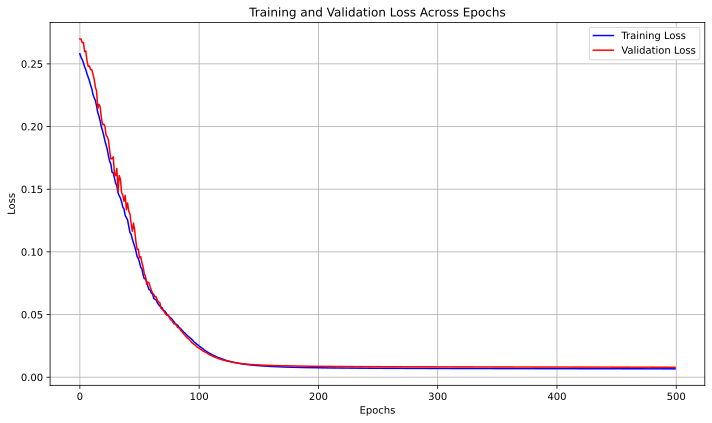

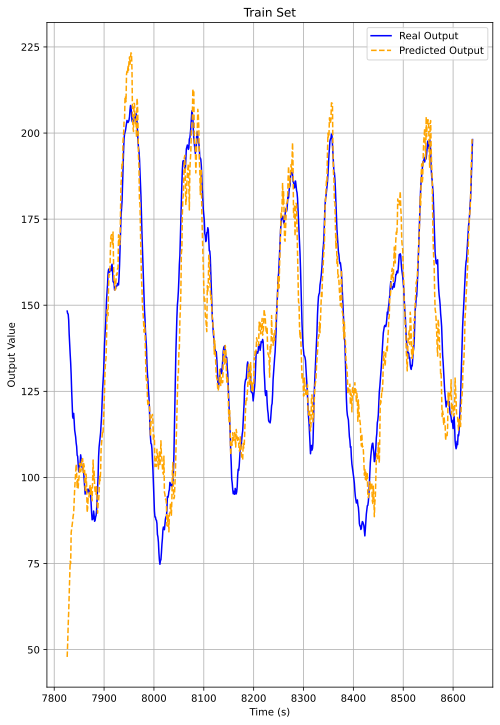

In [12]:
# --------------Plot identification results for S-----------------

#Training and Validation Loss Across Epochs
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), train_losses, label='Training Loss', color='blue')
plt.plot(range(epochs), val_losses, label='Validation Loss', color='red')  # Assuming val_losses are collected
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Across Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Model's Predictions vs Actual Output for the test set
fig, axes = plt.subplots(nrows=len(test_loader), ncols=1, figsize=(8, 12), sharex=True, sharey=True)

Dual_REN.to("cpu"); closed_loop_REN.to("cpu")
    

for u0_batch, _, _, u1_batch, y_batch, time in test_loader: # MH, I_rec (PID), R (noise + sat), I_sat (I_rec + R), CGM, time
    # u_batch.shape = batch_size   horizon   input_dim
    
    u0_batch, u1_batch, y_batch= ensure_3d(u0_batch), ensure_3d(u1_batch), ensure_3d(y_batch) # batch_size, time_horizon, input_dim
    u_batch = torch.cat((u0_batch, u1_batch), dim=2)  # concatenate along input dimension
    u_batch, y_batch = u_batch.to("cpu"), y_batch.to("cpu")
    

    Dual_REN.eval()
    _, y_hat = closed_loop_REN(x0, u_batch)
    
    loss_batch_val = MSE(y_batch, y_hat)

    loss_val_epoch += loss_batch_val.item()
    
    y_batch_np = scaler_glucose.denormalize(y_batch.detach().cpu()).numpy()
    y_hat_np = scaler_glucose.denormalize(y_hat.detach().cpu()).numpy()
    


plt.plot(time, y_batch_np[0, :, 0], label="Real Output", color="blue")
plt.plot(time, y_hat_np[0, :, 0], label="Predicted Output", linestyle="--", color="orange")
plt.title(f"Train Set")
plt.xlabel("Time (s)")
plt.ylabel("Output Value")
plt.legend()
plt.grid(True)
plt.show()

In [13]:
#-----------------------------closedloop sysid of S through RENs------------------------
#--------------------------Define model for sysid---------------------------------------------
#create the REN model for S
y_init = x0

REN_0 = REN_IQC_gamma(dim_in= input_dim[0], dim_out= output_dim[0], dim_internal=dim_internal[0], dim_nl= dim_nl[0], y_init = y_init[0], QR_fun = set_QR, gammat=gamma[0], IQC_type = IQC_type[0], device=device)

REN_S_2 = REN_IQC_gamma(dim_in= input_dim[1], dim_out= output_dim[1], dim_internal=dim_internal[1], dim_nl= dim_nl[1], y_init = y_init[1], QR_fun = set_QR, gammat=gamma[1], IQC_type = IQC_type[1], device=device)


#--------------------------Define the loss function and optimizer---------------------------------------------
MSE = nn.MSELoss()
optimizer = torch.optim.Adam( list(REN_0.parameters()) + list(REN_S_2.parameters()),   lr=learning_rate)
optimizer.zero_grad()

In [14]:
#--------------------------5. Training---------------------------------------------------------------------

REN_0 = REN_0.to(device)
REN_S_2 = REN_S_2.to(device)
print(f"[INFO] Training on device: {device}")

torch.set_default_dtype(torch.float32)  # default tensor dtype

train_losses = []
val_losses = []  # Store validation losses across epochs


for epoch in range(epochs):
    # ---------------- TRAINING ---------------- #
    REN_0.train(); REN_S_2.train()
    loss_epoch = 0.0  # Accumulate training loss

    for u0_batch, _, u1_batch, _, y_batch, _ in train_loader: # MH, I_rec (PID), R (noise + sat), I_sat (I_rec + R), CGM, time
        # u_batch.shape = batch_size   horizon   input_dim
        u0_batch, u1_batch, y_batch = ensure_3d(u0_batch), ensure_3d(u1_batch), ensure_3d(y_batch) # batch_size, time_horizon, input_dim
        u0_batch, u1_batch, y_batch = u0_batch.to(device), u1_batch.to(device), y_batch.to(device)


        optimizer.zero_grad()
        REN_0.reset(); REN_S_2.reset()
        
        
        y0_hat_train = REN_0(u0_batch) # forward
        y1_hat_train = REN_S_2(u1_batch) # forward
        y_hat_train = y0_hat_train - y1_hat_train 
        # with monotonicity we have forced a positive response from the insulin REN (REN_1) 
        # but from real-world knowledge it is a negative relation

        loss_batch = MSE(y_hat_train, y_batch)
        
        loss_batch.backward()
        optimizer.step()

        loss_epoch += loss_batch.item()

    loss_epoch /= len(train_loader)
    train_losses.append(loss_epoch)

    # ---------------- VALIDATION ---------------- #
    REN_0.eval(); REN_S_2.eval()
    loss_val_epoch = 0.0

    with torch.no_grad():
        for u0_batch, _, u1_batch, _, y_batch, _ in val_loader: # MH, I_rec (PID), R (noise + sat), I_sat (I_rec + R), CGM, time
            # u_batch.shape = batch_size   horizon   input_dim
            
            u0_batch, u1_batch, y_batch= ensure_3d(u0_batch), ensure_3d(u1_batch), ensure_3d(y_batch) # batch_size, time_horizon, input_dim
            u0_batch, u1_batch, y_batch = u0_batch.to(device), u1_batch.to(device), y_batch.to(device)
            
            REN_0.reset(); REN_S_2.reset()
            
            y0_hat_val = REN_0(u0_batch) # forward
            y1_hat_val = REN_S_2(u1_batch) # forward
            y_hat_val = y0_hat_val - y1_hat_val
            
            loss_batch_val = MSE(y_hat_val, y_batch)

            loss_val_epoch += loss_batch_val.item()

    if epoch == 0 or loss_val_epoch < min_val_loss:
        min_val_loss = loss_val_epoch
        epoch_when_model_saved = epoch
        candidate_REN_0 = REN_0
        candidate_REN_S_2 = REN_S_2

    loss_val_epoch /= len(val_loader)
    val_losses.append(loss_val_epoch)  # Store validation loss for plotting

    print(f"Epoch: {epoch + 1} \t||\t Training Loss: {loss_epoch:.6f} \t||\t Validation Loss: {loss_val_epoch:.6f}")

if redo_save:
    # model on CPU before saving
    candidate_REN_0_cpu = candidate_REN_0.to('cpu')
    candidate_REN_S_2_cpu = candidate_REN_S_2.to('cpu')

    # Save the best model
    # 1. Create models directory
    patient_str = "/paz_" + str(int(patient)).zfill(3)
    patient_model_folder = model_folder + "/"+ "strategy_3" + "/" + patient_str
    MODEL_PATH = Path(patient_model_folder)
    MODEL_PATH.mkdir(parents = True, exist_ok = True)
    # 2. save model state dict
    torch.save({
    'REN_0_state_dict': candidate_REN_0_cpu.state_dict(),
    'REN_S_2_state_dict': candidate_REN_S_2_cpu.state_dict()}, MODEL_PATH / 'trained_models.pth')


    # save .mat
    np_x0 = x0.detach().cpu().numpy(); np_input_dim = np.array(input_dim); np_output_dim = np.array(output_dim); np_dim_internal =np.array(dim_internal); np_dim_nl = np.array(dim_nl)
    np_y_init = y_init.cpu().numpy(); np_gamma = gamma.cpu().numpy()
    
    # 4. Create params directory
    params_folder = Path(patient_model_folder) / "params"
    params_folder.mkdir(parents=True, exist_ok=True)
    scipy.io.savemat(params_folder / 'parameters.mat', {'train_losses': train_losses, 'val_losses': val_losses, 'epoch_when_model_saved': epoch_when_model_saved, 'x0': np_x0, 'input_dim': np_input_dim, 'output_dim': np_output_dim, 'dim_internal': np_dim_internal, 'dim_nl': np_dim_nl, 'y_init': np_y_init, 'gamma': np_gamma})
    
Dual_REN = DualREN(candidate_REN_0_cpu, candidate_REN_S_2_cpu)
controller = NonLinearController(loaded_parameters, PID_functions, dataset.basal_vec, scaler_glucose, scaler_insulin, scaler_meal, use_noise)
closed_loop_REN_2 = ClosedLoopSystem(Dual_REN, controller, negative=True)

closed_loop_closed_loop_2 = ClosedLoopSystem(closed_loop_REN_2, controller)

[INFO] Training on device: cpu


Epoch: 1 	||	 Training Loss: 0.276986 	||	 Validation Loss: 0.293547


Epoch: 2 	||	 Training Loss: 0.276853 	||	 Validation Loss: 0.293405


Epoch: 3 	||	 Training Loss: 0.276721 	||	 Validation Loss: 0.293266


Epoch: 4 	||	 Training Loss: 0.276592 	||	 Validation Loss: 0.293130


Epoch: 5 	||	 Training Loss: 0.276466 	||	 Validation Loss: 0.292997


Epoch: 6 	||	 Training Loss: 0.276342 	||	 Validation Loss: 0.292866


Epoch: 7 	||	 Training Loss: 0.276221 	||	 Validation Loss: 0.292738


Epoch: 8 	||	 Training Loss: 0.276102 	||	 Validation Loss: 0.292613


Epoch: 9 	||	 Training Loss: 0.275985 	||	 Validation Loss: 0.292490


Epoch: 10 	||	 Training Loss: 0.275871 	||	 Validation Loss: 0.292370


Epoch: 11 	||	 Training Loss: 0.275759 	||	 Validation Loss: 0.292253


Epoch: 12 	||	 Training Loss: 0.275650 	||	 Validation Loss: 0.292138


Epoch: 13 	||	 Training Loss: 0.275543 	||	 Validation Loss: 0.292025


Epoch: 14 	||	 Training Loss: 0.275438 	||	 Validation Loss: 0.291915


Epoch: 15 	||	 Training Loss: 0.275336 	||	 Validation Loss: 0.291807


Epoch: 16 	||	 Training Loss: 0.275235 	||	 Validation Loss: 0.291701


Epoch: 17 	||	 Training Loss: 0.275137 	||	 Validation Loss: 0.291597


Epoch: 18 	||	 Training Loss: 0.275040 	||	 Validation Loss: 0.291496


Epoch: 19 	||	 Training Loss: 0.274946 	||	 Validation Loss: 0.291396


Epoch: 20 	||	 Training Loss: 0.274853 	||	 Validation Loss: 0.291298


Epoch: 21 	||	 Training Loss: 0.274762 	||	 Validation Loss: 0.291202


Epoch: 22 	||	 Training Loss: 0.274673 	||	 Validation Loss: 0.291108


Epoch: 23 	||	 Training Loss: 0.274585 	||	 Validation Loss: 0.291016


Epoch: 24 	||	 Training Loss: 0.274499 	||	 Validation Loss: 0.290925


Epoch: 25 	||	 Training Loss: 0.274415 	||	 Validation Loss: 0.290836


Epoch: 26 	||	 Training Loss: 0.274332 	||	 Validation Loss: 0.290748


Epoch: 27 	||	 Training Loss: 0.274251 	||	 Validation Loss: 0.290662


Epoch: 28 	||	 Training Loss: 0.274171 	||	 Validation Loss: 0.290577


Epoch: 29 	||	 Training Loss: 0.274092 	||	 Validation Loss: 0.290493


Epoch: 30 	||	 Training Loss: 0.274014 	||	 Validation Loss: 0.290410


Epoch: 31 	||	 Training Loss: 0.273938 	||	 Validation Loss: 0.290327


Epoch: 32 	||	 Training Loss: 0.273862 	||	 Validation Loss: 0.290246


Epoch: 33 	||	 Training Loss: 0.273787 	||	 Validation Loss: 0.290165


Epoch: 34 	||	 Training Loss: 0.273713 	||	 Validation Loss: 0.290085


Epoch: 35 	||	 Training Loss: 0.273639 	||	 Validation Loss: 0.290005


Epoch: 36 	||	 Training Loss: 0.273566 	||	 Validation Loss: 0.289925


Epoch: 37 	||	 Training Loss: 0.273493 	||	 Validation Loss: 0.289844


Epoch: 38 	||	 Training Loss: 0.273420 	||	 Validation Loss: 0.289764


Epoch: 39 	||	 Training Loss: 0.273347 	||	 Validation Loss: 0.289683


Epoch: 40 	||	 Training Loss: 0.273273 	||	 Validation Loss: 0.289601


Epoch: 41 	||	 Training Loss: 0.273199 	||	 Validation Loss: 0.289518


Epoch: 42 	||	 Training Loss: 0.273125 	||	 Validation Loss: 0.289434


Epoch: 43 	||	 Training Loss: 0.273050 	||	 Validation Loss: 0.289349


Epoch: 44 	||	 Training Loss: 0.272973 	||	 Validation Loss: 0.289263


Epoch: 45 	||	 Training Loss: 0.272896 	||	 Validation Loss: 0.289175


Epoch: 46 	||	 Training Loss: 0.272818 	||	 Validation Loss: 0.289085


Epoch: 47 	||	 Training Loss: 0.272738 	||	 Validation Loss: 0.288993


Epoch: 48 	||	 Training Loss: 0.272656 	||	 Validation Loss: 0.288899


Epoch: 49 	||	 Training Loss: 0.272573 	||	 Validation Loss: 0.288802


Epoch: 50 	||	 Training Loss: 0.272488 	||	 Validation Loss: 0.288703


Epoch: 51 	||	 Training Loss: 0.272400 	||	 Validation Loss: 0.288601


Epoch: 52 	||	 Training Loss: 0.272311 	||	 Validation Loss: 0.288496


Epoch: 53 	||	 Training Loss: 0.272219 	||	 Validation Loss: 0.288388


Epoch: 54 	||	 Training Loss: 0.272124 	||	 Validation Loss: 0.288277


Epoch: 55 	||	 Training Loss: 0.272026 	||	 Validation Loss: 0.288161


Epoch: 56 	||	 Training Loss: 0.271925 	||	 Validation Loss: 0.288042


Epoch: 57 	||	 Training Loss: 0.271821 	||	 Validation Loss: 0.287918


Epoch: 58 	||	 Training Loss: 0.271713 	||	 Validation Loss: 0.287790


Epoch: 59 	||	 Training Loss: 0.271601 	||	 Validation Loss: 0.287657


Epoch: 60 	||	 Training Loss: 0.271485 	||	 Validation Loss: 0.287519


Epoch: 61 	||	 Training Loss: 0.271365 	||	 Validation Loss: 0.287375


Epoch: 62 	||	 Training Loss: 0.271239 	||	 Validation Loss: 0.287225


Epoch: 63 	||	 Training Loss: 0.271109 	||	 Validation Loss: 0.287069


Epoch: 64 	||	 Training Loss: 0.270973 	||	 Validation Loss: 0.286906


Epoch: 65 	||	 Training Loss: 0.270831 	||	 Validation Loss: 0.286735


Epoch: 66 	||	 Training Loss: 0.270683 	||	 Validation Loss: 0.286557


Epoch: 67 	||	 Training Loss: 0.270528 	||	 Validation Loss: 0.286370


Epoch: 68 	||	 Training Loss: 0.270365 	||	 Validation Loss: 0.286174


Epoch: 69 	||	 Training Loss: 0.270194 	||	 Validation Loss: 0.285968


Epoch: 70 	||	 Training Loss: 0.270015 	||	 Validation Loss: 0.285751


Epoch: 71 	||	 Training Loss: 0.269826 	||	 Validation Loss: 0.285522


Epoch: 72 	||	 Training Loss: 0.269626 	||	 Validation Loss: 0.285280


Epoch: 73 	||	 Training Loss: 0.269415 	||	 Validation Loss: 0.285025


Epoch: 74 	||	 Training Loss: 0.269192 	||	 Validation Loss: 0.284754


Epoch: 75 	||	 Training Loss: 0.268955 	||	 Validation Loss: 0.284466


Epoch: 76 	||	 Training Loss: 0.268703 	||	 Validation Loss: 0.284160


Epoch: 77 	||	 Training Loss: 0.268435 	||	 Validation Loss: 0.283834


Epoch: 78 	||	 Training Loss: 0.268148 	||	 Validation Loss: 0.283486


Epoch: 79 	||	 Training Loss: 0.267841 	||	 Validation Loss: 0.283112


Epoch: 80 	||	 Training Loss: 0.267512 	||	 Validation Loss: 0.282712


Epoch: 81 	||	 Training Loss: 0.267159 	||	 Validation Loss: 0.282281


Epoch: 82 	||	 Training Loss: 0.266777 	||	 Validation Loss: 0.281816


Epoch: 83 	||	 Training Loss: 0.266365 	||	 Validation Loss: 0.281313


Epoch: 84 	||	 Training Loss: 0.265918 	||	 Validation Loss: 0.280768


Epoch: 85 	||	 Training Loss: 0.265433 	||	 Validation Loss: 0.280176


Epoch: 86 	||	 Training Loss: 0.264904 	||	 Validation Loss: 0.279531


Epoch: 87 	||	 Training Loss: 0.264327 	||	 Validation Loss: 0.278825


Epoch: 88 	||	 Training Loss: 0.263694 	||	 Validation Loss: 0.278053


Epoch: 89 	||	 Training Loss: 0.262999 	||	 Validation Loss: 0.277205


Epoch: 90 	||	 Training Loss: 0.262234 	||	 Validation Loss: 0.276271


Epoch: 91 	||	 Training Loss: 0.261388 	||	 Validation Loss: 0.275239


Epoch: 92 	||	 Training Loss: 0.260452 	||	 Validation Loss: 0.274099


Epoch: 93 	||	 Training Loss: 0.259413 	||	 Validation Loss: 0.272834


Epoch: 94 	||	 Training Loss: 0.258257 	||	 Validation Loss: 0.271428


Epoch: 95 	||	 Training Loss: 0.256968 	||	 Validation Loss: 0.269864


Epoch: 96 	||	 Training Loss: 0.255529 	||	 Validation Loss: 0.268122


Epoch: 97 	||	 Training Loss: 0.253920 	||	 Validation Loss: 0.266180


Epoch: 98 	||	 Training Loss: 0.252120 	||	 Validation Loss: 0.264015


Epoch: 99 	||	 Training Loss: 0.250108 	||	 Validation Loss: 0.261606


Epoch: 100 	||	 Training Loss: 0.247861 	||	 Validation Loss: 0.258931


Epoch: 101 	||	 Training Loss: 0.245359 	||	 Validation Loss: 0.255969


Epoch: 102 	||	 Training Loss: 0.242582 	||	 Validation Loss: 0.252705


Epoch: 103 	||	 Training Loss: 0.239515 	||	 Validation Loss: 0.249129


Epoch: 104 	||	 Training Loss: 0.236146 	||	 Validation Loss: 0.245234


Epoch: 105 	||	 Training Loss: 0.232470 	||	 Validation Loss: 0.241020


Epoch: 106 	||	 Training Loss: 0.228484 	||	 Validation Loss: 0.236493


Epoch: 107 	||	 Training Loss: 0.224194 	||	 Validation Loss: 0.231664


Epoch: 108 	||	 Training Loss: 0.219605 	||	 Validation Loss: 0.226545


Epoch: 109 	||	 Training Loss: 0.214729 	||	 Validation Loss: 0.221150


Epoch: 110 	||	 Training Loss: 0.209575 	||	 Validation Loss: 0.215497


Epoch: 111 	||	 Training Loss: 0.204155 	||	 Validation Loss: 0.209607


Epoch: 112 	||	 Training Loss: 0.198486 	||	 Validation Loss: 0.203507


Epoch: 113 	||	 Training Loss: 0.192588 	||	 Validation Loss: 0.197226


Epoch: 114 	||	 Training Loss: 0.186488 	||	 Validation Loss: 0.190797


Epoch: 115 	||	 Training Loss: 0.180215 	||	 Validation Loss: 0.184250


Epoch: 116 	||	 Training Loss: 0.173795 	||	 Validation Loss: 0.177613


Epoch: 117 	||	 Training Loss: 0.167256 	||	 Validation Loss: 0.170915


Epoch: 118 	||	 Training Loss: 0.160629 	||	 Validation Loss: 0.164190


Epoch: 119 	||	 Training Loss: 0.153948 	||	 Validation Loss: 0.157478


Epoch: 120 	||	 Training Loss: 0.147253 	||	 Validation Loss: 0.150822


Epoch: 121 	||	 Training Loss: 0.140592 	||	 Validation Loss: 0.144268


Epoch: 122 	||	 Training Loss: 0.134014 	||	 Validation Loss: 0.137865


Epoch: 123 	||	 Training Loss: 0.127569 	||	 Validation Loss: 0.131655


Epoch: 124 	||	 Training Loss: 0.121304 	||	 Validation Loss: 0.125670


Epoch: 125 	||	 Training Loss: 0.115254 	||	 Validation Loss: 0.119932


Epoch: 126 	||	 Training Loss: 0.109444 	||	 Validation Loss: 0.114450


Epoch: 127 	||	 Training Loss: 0.103884 	||	 Validation Loss: 0.109222


Epoch: 128 	||	 Training Loss: 0.098575 	||	 Validation Loss: 0.104242


Epoch: 129 	||	 Training Loss: 0.093513 	||	 Validation Loss: 0.099500


Epoch: 130 	||	 Training Loss: 0.088689 	||	 Validation Loss: 0.094994


Epoch: 131 	||	 Training Loss: 0.084103 	||	 Validation Loss: 0.090720


Epoch: 132 	||	 Training Loss: 0.079754 	||	 Validation Loss: 0.086685


Epoch: 133 	||	 Training Loss: 0.075650 	||	 Validation Loss: 0.082895


Epoch: 134 	||	 Training Loss: 0.071798 	||	 Validation Loss: 0.079359


Epoch: 135 	||	 Training Loss: 0.068211 	||	 Validation Loss: 0.076087


Epoch: 136 	||	 Training Loss: 0.064898 	||	 Validation Loss: 0.073084


Epoch: 137 	||	 Training Loss: 0.061865 	||	 Validation Loss: 0.070353


Epoch: 138 	||	 Training Loss: 0.059119 	||	 Validation Loss: 0.067893


Epoch: 139 	||	 Training Loss: 0.056658 	||	 Validation Loss: 0.065700


Epoch: 140 	||	 Training Loss: 0.054478 	||	 Validation Loss: 0.063765


Epoch: 141 	||	 Training Loss: 0.052570 	||	 Validation Loss: 0.062073


Epoch: 142 	||	 Training Loss: 0.050919 	||	 Validation Loss: 0.060609


Epoch: 143 	||	 Training Loss: 0.049507 	||	 Validation Loss: 0.059348


Epoch: 144 	||	 Training Loss: 0.048309 	||	 Validation Loss: 0.058267


Epoch: 145 	||	 Training Loss: 0.047297 	||	 Validation Loss: 0.057338


Epoch: 146 	||	 Training Loss: 0.046439 	||	 Validation Loss: 0.056531


Epoch: 147 	||	 Training Loss: 0.045703 	||	 Validation Loss: 0.055819


Epoch: 148 	||	 Training Loss: 0.045056 	||	 Validation Loss: 0.055177


Epoch: 149 	||	 Training Loss: 0.044468 	||	 Validation Loss: 0.054583


Epoch: 150 	||	 Training Loss: 0.043913 	||	 Validation Loss: 0.054021


Epoch: 151 	||	 Training Loss: 0.043372 	||	 Validation Loss: 0.053485


Epoch: 152 	||	 Training Loss: 0.042835 	||	 Validation Loss: 0.052971


Epoch: 153 	||	 Training Loss: 0.042296 	||	 Validation Loss: 0.052486


Epoch: 154 	||	 Training Loss: 0.041760 	||	 Validation Loss: 0.052039


Epoch: 155 	||	 Training Loss: 0.041238 	||	 Validation Loss: 0.051646


Epoch: 156 	||	 Training Loss: 0.040747 	||	 Validation Loss: 0.051319


Epoch: 157 	||	 Training Loss: 0.040304 	||	 Validation Loss: 0.051066


Epoch: 158 	||	 Training Loss: 0.039921 	||	 Validation Loss: 0.050881


Epoch: 159 	||	 Training Loss: 0.039604 	||	 Validation Loss: 0.050749


Epoch: 160 	||	 Training Loss: 0.039341 	||	 Validation Loss: 0.050638


Epoch: 161 	||	 Training Loss: 0.039112 	||	 Validation Loss: 0.050518


Epoch: 162 	||	 Training Loss: 0.038892 	||	 Validation Loss: 0.050364


Epoch: 163 	||	 Training Loss: 0.038660 	||	 Validation Loss: 0.050170


Epoch: 164 	||	 Training Loss: 0.038411 	||	 Validation Loss: 0.049944


Epoch: 165 	||	 Training Loss: 0.038153 	||	 Validation Loss: 0.049704


Epoch: 166 	||	 Training Loss: 0.037902 	||	 Validation Loss: 0.049470


Epoch: 167 	||	 Training Loss: 0.037670 	||	 Validation Loss: 0.049254


Epoch: 168 	||	 Training Loss: 0.037465 	||	 Validation Loss: 0.049063


Epoch: 169 	||	 Training Loss: 0.037286 	||	 Validation Loss: 0.048897


Epoch: 170 	||	 Training Loss: 0.037129 	||	 Validation Loss: 0.048753


Epoch: 171 	||	 Training Loss: 0.036987 	||	 Validation Loss: 0.048628


Epoch: 172 	||	 Training Loss: 0.036853 	||	 Validation Loss: 0.048519


Epoch: 173 	||	 Training Loss: 0.036722 	||	 Validation Loss: 0.048424


Epoch: 174 	||	 Training Loss: 0.036593 	||	 Validation Loss: 0.048343


Epoch: 175 	||	 Training Loss: 0.036465 	||	 Validation Loss: 0.048276


Epoch: 176 	||	 Training Loss: 0.036340 	||	 Validation Loss: 0.048224


Epoch: 177 	||	 Training Loss: 0.036220 	||	 Validation Loss: 0.048186


Epoch: 178 	||	 Training Loss: 0.036107 	||	 Validation Loss: 0.048161


Epoch: 179 	||	 Training Loss: 0.036002 	||	 Validation Loss: 0.048144


Epoch: 180 	||	 Training Loss: 0.035907 	||	 Validation Loss: 0.048132


Epoch: 181 	||	 Training Loss: 0.035820 	||	 Validation Loss: 0.048118


Epoch: 182 	||	 Training Loss: 0.035739 	||	 Validation Loss: 0.048096


Epoch: 183 	||	 Training Loss: 0.035661 	||	 Validation Loss: 0.048063


Epoch: 184 	||	 Training Loss: 0.035584 	||	 Validation Loss: 0.048015


Epoch: 185 	||	 Training Loss: 0.035507 	||	 Validation Loss: 0.047954


Epoch: 186 	||	 Training Loss: 0.035429 	||	 Validation Loss: 0.047883


Epoch: 187 	||	 Training Loss: 0.035352 	||	 Validation Loss: 0.047806


Epoch: 188 	||	 Training Loss: 0.035278 	||	 Validation Loss: 0.047729


Epoch: 189 	||	 Training Loss: 0.035208 	||	 Validation Loss: 0.047654


Epoch: 190 	||	 Training Loss: 0.035143 	||	 Validation Loss: 0.047586


Epoch: 191 	||	 Training Loss: 0.035081 	||	 Validation Loss: 0.047525


Epoch: 192 	||	 Training Loss: 0.035022 	||	 Validation Loss: 0.047473


Epoch: 193 	||	 Training Loss: 0.034966 	||	 Validation Loss: 0.047429


Epoch: 194 	||	 Training Loss: 0.034910 	||	 Validation Loss: 0.047395


Epoch: 195 	||	 Training Loss: 0.034854 	||	 Validation Loss: 0.047368


Epoch: 196 	||	 Training Loss: 0.034799 	||	 Validation Loss: 0.047347


Epoch: 197 	||	 Training Loss: 0.034746 	||	 Validation Loss: 0.047332


Epoch: 198 	||	 Training Loss: 0.034694 	||	 Validation Loss: 0.047319


Epoch: 199 	||	 Training Loss: 0.034645 	||	 Validation Loss: 0.047305


Epoch: 200 	||	 Training Loss: 0.034598 	||	 Validation Loss: 0.047289


Epoch: 201 	||	 Training Loss: 0.034553 	||	 Validation Loss: 0.047265


Epoch: 202 	||	 Training Loss: 0.034508 	||	 Validation Loss: 0.047235


Epoch: 203 	||	 Training Loss: 0.034464 	||	 Validation Loss: 0.047196


Epoch: 204 	||	 Training Loss: 0.034421 	||	 Validation Loss: 0.047151


Epoch: 205 	||	 Training Loss: 0.034378 	||	 Validation Loss: 0.047103


Epoch: 206 	||	 Training Loss: 0.034335 	||	 Validation Loss: 0.047053


Epoch: 207 	||	 Training Loss: 0.034294 	||	 Validation Loss: 0.047005


Epoch: 208 	||	 Training Loss: 0.034254 	||	 Validation Loss: 0.046961


Epoch: 209 	||	 Training Loss: 0.034216 	||	 Validation Loss: 0.046922


Epoch: 210 	||	 Training Loss: 0.034178 	||	 Validation Loss: 0.046889


Epoch: 211 	||	 Training Loss: 0.034141 	||	 Validation Loss: 0.046861


Epoch: 212 	||	 Training Loss: 0.034104 	||	 Validation Loss: 0.046839


Epoch: 213 	||	 Training Loss: 0.034068 	||	 Validation Loss: 0.046820


Epoch: 214 	||	 Training Loss: 0.034033 	||	 Validation Loss: 0.046803


Epoch: 215 	||	 Training Loss: 0.033998 	||	 Validation Loss: 0.046787


Epoch: 216 	||	 Training Loss: 0.033964 	||	 Validation Loss: 0.046768


Epoch: 217 	||	 Training Loss: 0.033931 	||	 Validation Loss: 0.046747


Epoch: 218 	||	 Training Loss: 0.033899 	||	 Validation Loss: 0.046721


Epoch: 219 	||	 Training Loss: 0.033866 	||	 Validation Loss: 0.046691


Epoch: 220 	||	 Training Loss: 0.033834 	||	 Validation Loss: 0.046659


Epoch: 221 	||	 Training Loss: 0.033803 	||	 Validation Loss: 0.046625


Epoch: 222 	||	 Training Loss: 0.033772 	||	 Validation Loss: 0.046591


Epoch: 223 	||	 Training Loss: 0.033742 	||	 Validation Loss: 0.046559


Epoch: 224 	||	 Training Loss: 0.033712 	||	 Validation Loss: 0.046530


Epoch: 225 	||	 Training Loss: 0.033683 	||	 Validation Loss: 0.046504


Epoch: 226 	||	 Training Loss: 0.033654 	||	 Validation Loss: 0.046481


Epoch: 227 	||	 Training Loss: 0.033625 	||	 Validation Loss: 0.046462


Epoch: 228 	||	 Training Loss: 0.033597 	||	 Validation Loss: 0.046444


Epoch: 229 	||	 Training Loss: 0.033569 	||	 Validation Loss: 0.046427


Epoch: 230 	||	 Training Loss: 0.033542 	||	 Validation Loss: 0.046410


Epoch: 231 	||	 Training Loss: 0.033515 	||	 Validation Loss: 0.046392


Epoch: 232 	||	 Training Loss: 0.033488 	||	 Validation Loss: 0.046372


Epoch: 233 	||	 Training Loss: 0.033462 	||	 Validation Loss: 0.046350


Epoch: 234 	||	 Training Loss: 0.033436 	||	 Validation Loss: 0.046326


Epoch: 235 	||	 Training Loss: 0.033410 	||	 Validation Loss: 0.046302


Epoch: 236 	||	 Training Loss: 0.033385 	||	 Validation Loss: 0.046278


Epoch: 237 	||	 Training Loss: 0.033360 	||	 Validation Loss: 0.046254


Epoch: 238 	||	 Training Loss: 0.033335 	||	 Validation Loss: 0.046232


Epoch: 239 	||	 Training Loss: 0.033311 	||	 Validation Loss: 0.046212


Epoch: 240 	||	 Training Loss: 0.033286 	||	 Validation Loss: 0.046194


Epoch: 241 	||	 Training Loss: 0.033262 	||	 Validation Loss: 0.046178


Epoch: 242 	||	 Training Loss: 0.033239 	||	 Validation Loss: 0.046163


Epoch: 243 	||	 Training Loss: 0.033216 	||	 Validation Loss: 0.046148


Epoch: 244 	||	 Training Loss: 0.033192 	||	 Validation Loss: 0.046133


Epoch: 245 	||	 Training Loss: 0.033170 	||	 Validation Loss: 0.046117


Epoch: 246 	||	 Training Loss: 0.033147 	||	 Validation Loss: 0.046100


Epoch: 247 	||	 Training Loss: 0.033125 	||	 Validation Loss: 0.046081


Epoch: 248 	||	 Training Loss: 0.033103 	||	 Validation Loss: 0.046063


Epoch: 249 	||	 Training Loss: 0.033081 	||	 Validation Loss: 0.046044


Epoch: 250 	||	 Training Loss: 0.033059 	||	 Validation Loss: 0.046025


Epoch: 251 	||	 Training Loss: 0.033038 	||	 Validation Loss: 0.046007


Epoch: 252 	||	 Training Loss: 0.033017 	||	 Validation Loss: 0.045991


Epoch: 253 	||	 Training Loss: 0.032996 	||	 Validation Loss: 0.045975


Epoch: 254 	||	 Training Loss: 0.032975 	||	 Validation Loss: 0.045960


Epoch: 255 	||	 Training Loss: 0.032954 	||	 Validation Loss: 0.045946


Epoch: 256 	||	 Training Loss: 0.032934 	||	 Validation Loss: 0.045932


Epoch: 257 	||	 Training Loss: 0.032914 	||	 Validation Loss: 0.045918


Epoch: 258 	||	 Training Loss: 0.032894 	||	 Validation Loss: 0.045903


Epoch: 259 	||	 Training Loss: 0.032874 	||	 Validation Loss: 0.045887


Epoch: 260 	||	 Training Loss: 0.032855 	||	 Validation Loss: 0.045871


Epoch: 261 	||	 Training Loss: 0.032835 	||	 Validation Loss: 0.045855


Epoch: 262 	||	 Training Loss: 0.032816 	||	 Validation Loss: 0.045839


Epoch: 263 	||	 Training Loss: 0.032797 	||	 Validation Loss: 0.045823


Epoch: 264 	||	 Training Loss: 0.032778 	||	 Validation Loss: 0.045808


Epoch: 265 	||	 Training Loss: 0.032760 	||	 Validation Loss: 0.045793


Epoch: 266 	||	 Training Loss: 0.032741 	||	 Validation Loss: 0.045779


Epoch: 267 	||	 Training Loss: 0.032723 	||	 Validation Loss: 0.045765


Epoch: 268 	||	 Training Loss: 0.032705 	||	 Validation Loss: 0.045751


Epoch: 269 	||	 Training Loss: 0.032687 	||	 Validation Loss: 0.045738


Epoch: 270 	||	 Training Loss: 0.032669 	||	 Validation Loss: 0.045724


Epoch: 271 	||	 Training Loss: 0.032651 	||	 Validation Loss: 0.045709


Epoch: 272 	||	 Training Loss: 0.032633 	||	 Validation Loss: 0.045695


Epoch: 273 	||	 Training Loss: 0.032616 	||	 Validation Loss: 0.045680


Epoch: 274 	||	 Training Loss: 0.032599 	||	 Validation Loss: 0.045665


Epoch: 275 	||	 Training Loss: 0.032582 	||	 Validation Loss: 0.045651


Epoch: 276 	||	 Training Loss: 0.032565 	||	 Validation Loss: 0.045637


Epoch: 277 	||	 Training Loss: 0.032548 	||	 Validation Loss: 0.045623


Epoch: 278 	||	 Training Loss: 0.032531 	||	 Validation Loss: 0.045609


Epoch: 279 	||	 Training Loss: 0.032515 	||	 Validation Loss: 0.045596


Epoch: 280 	||	 Training Loss: 0.032498 	||	 Validation Loss: 0.045583


Epoch: 281 	||	 Training Loss: 0.032482 	||	 Validation Loss: 0.045570


Epoch: 282 	||	 Training Loss: 0.032466 	||	 Validation Loss: 0.045556


Epoch: 283 	||	 Training Loss: 0.032450 	||	 Validation Loss: 0.045543


Epoch: 284 	||	 Training Loss: 0.032434 	||	 Validation Loss: 0.045529


Epoch: 285 	||	 Training Loss: 0.032418 	||	 Validation Loss: 0.045516


Epoch: 286 	||	 Training Loss: 0.032403 	||	 Validation Loss: 0.045502


Epoch: 287 	||	 Training Loss: 0.032387 	||	 Validation Loss: 0.045489


Epoch: 288 	||	 Training Loss: 0.032372 	||	 Validation Loss: 0.045476


Epoch: 289 	||	 Training Loss: 0.032357 	||	 Validation Loss: 0.045463


Epoch: 290 	||	 Training Loss: 0.032342 	||	 Validation Loss: 0.045450


Epoch: 291 	||	 Training Loss: 0.032327 	||	 Validation Loss: 0.045438


Epoch: 292 	||	 Training Loss: 0.032312 	||	 Validation Loss: 0.045425


Epoch: 293 	||	 Training Loss: 0.032297 	||	 Validation Loss: 0.045413


Epoch: 294 	||	 Training Loss: 0.032282 	||	 Validation Loss: 0.045400


Epoch: 295 	||	 Training Loss: 0.032268 	||	 Validation Loss: 0.045387


Epoch: 296 	||	 Training Loss: 0.032253 	||	 Validation Loss: 0.045375


Epoch: 297 	||	 Training Loss: 0.032239 	||	 Validation Loss: 0.045362


Epoch: 298 	||	 Training Loss: 0.032225 	||	 Validation Loss: 0.045350


Epoch: 299 	||	 Training Loss: 0.032210 	||	 Validation Loss: 0.045338


Epoch: 300 	||	 Training Loss: 0.032196 	||	 Validation Loss: 0.045326


Epoch: 301 	||	 Training Loss: 0.032182 	||	 Validation Loss: 0.045313


Epoch: 302 	||	 Training Loss: 0.032169 	||	 Validation Loss: 0.045302


Epoch: 303 	||	 Training Loss: 0.032155 	||	 Validation Loss: 0.045290


Epoch: 304 	||	 Training Loss: 0.032141 	||	 Validation Loss: 0.045278


Epoch: 305 	||	 Training Loss: 0.032128 	||	 Validation Loss: 0.045266


Epoch: 306 	||	 Training Loss: 0.032114 	||	 Validation Loss: 0.045254


Epoch: 307 	||	 Training Loss: 0.032101 	||	 Validation Loss: 0.045242


Epoch: 308 	||	 Training Loss: 0.032087 	||	 Validation Loss: 0.045231


Epoch: 309 	||	 Training Loss: 0.032074 	||	 Validation Loss: 0.045219


Epoch: 310 	||	 Training Loss: 0.032061 	||	 Validation Loss: 0.045207


Epoch: 311 	||	 Training Loss: 0.032048 	||	 Validation Loss: 0.045196


Epoch: 312 	||	 Training Loss: 0.032035 	||	 Validation Loss: 0.045185


Epoch: 313 	||	 Training Loss: 0.032022 	||	 Validation Loss: 0.045173


Epoch: 314 	||	 Training Loss: 0.032010 	||	 Validation Loss: 0.045162


Epoch: 315 	||	 Training Loss: 0.031997 	||	 Validation Loss: 0.045151


Epoch: 316 	||	 Training Loss: 0.031984 	||	 Validation Loss: 0.045139


Epoch: 317 	||	 Training Loss: 0.031972 	||	 Validation Loss: 0.045128


Epoch: 318 	||	 Training Loss: 0.031959 	||	 Validation Loss: 0.045117


Epoch: 319 	||	 Training Loss: 0.031947 	||	 Validation Loss: 0.045106


Epoch: 320 	||	 Training Loss: 0.031935 	||	 Validation Loss: 0.045094


Epoch: 321 	||	 Training Loss: 0.031923 	||	 Validation Loss: 0.045083


Epoch: 322 	||	 Training Loss: 0.031911 	||	 Validation Loss: 0.045072


Epoch: 323 	||	 Training Loss: 0.031898 	||	 Validation Loss: 0.045061


Epoch: 324 	||	 Training Loss: 0.031887 	||	 Validation Loss: 0.045050


Epoch: 325 	||	 Training Loss: 0.031875 	||	 Validation Loss: 0.045039


Epoch: 326 	||	 Training Loss: 0.031863 	||	 Validation Loss: 0.045029


Epoch: 327 	||	 Training Loss: 0.031851 	||	 Validation Loss: 0.045018


Epoch: 328 	||	 Training Loss: 0.031839 	||	 Validation Loss: 0.045007


Epoch: 329 	||	 Training Loss: 0.031828 	||	 Validation Loss: 0.044996


Epoch: 330 	||	 Training Loss: 0.031816 	||	 Validation Loss: 0.044985


Epoch: 331 	||	 Training Loss: 0.031805 	||	 Validation Loss: 0.044975


Epoch: 332 	||	 Training Loss: 0.031793 	||	 Validation Loss: 0.044964


Epoch: 333 	||	 Training Loss: 0.031782 	||	 Validation Loss: 0.044954


Epoch: 334 	||	 Training Loss: 0.031771 	||	 Validation Loss: 0.044943


Epoch: 335 	||	 Training Loss: 0.031760 	||	 Validation Loss: 0.044932


Epoch: 336 	||	 Training Loss: 0.031749 	||	 Validation Loss: 0.044922


Epoch: 337 	||	 Training Loss: 0.031738 	||	 Validation Loss: 0.044911


Epoch: 338 	||	 Training Loss: 0.031727 	||	 Validation Loss: 0.044901


Epoch: 339 	||	 Training Loss: 0.031716 	||	 Validation Loss: 0.044891


Epoch: 340 	||	 Training Loss: 0.031705 	||	 Validation Loss: 0.044880


Epoch: 341 	||	 Training Loss: 0.031694 	||	 Validation Loss: 0.044870


Epoch: 342 	||	 Training Loss: 0.031683 	||	 Validation Loss: 0.044859


Epoch: 343 	||	 Training Loss: 0.031673 	||	 Validation Loss: 0.044849


Epoch: 344 	||	 Training Loss: 0.031662 	||	 Validation Loss: 0.044839


Epoch: 345 	||	 Training Loss: 0.031651 	||	 Validation Loss: 0.044829


Epoch: 346 	||	 Training Loss: 0.031641 	||	 Validation Loss: 0.044818


Epoch: 347 	||	 Training Loss: 0.031630 	||	 Validation Loss: 0.044809


Epoch: 348 	||	 Training Loss: 0.031620 	||	 Validation Loss: 0.044798


Epoch: 349 	||	 Training Loss: 0.031610 	||	 Validation Loss: 0.044788


Epoch: 350 	||	 Training Loss: 0.031600 	||	 Validation Loss: 0.044778


Epoch: 351 	||	 Training Loss: 0.031589 	||	 Validation Loss: 0.044768


Epoch: 352 	||	 Training Loss: 0.031579 	||	 Validation Loss: 0.044758


Epoch: 353 	||	 Training Loss: 0.031569 	||	 Validation Loss: 0.044748


Epoch: 354 	||	 Training Loss: 0.031559 	||	 Validation Loss: 0.044738


Epoch: 355 	||	 Training Loss: 0.031549 	||	 Validation Loss: 0.044728


Epoch: 356 	||	 Training Loss: 0.031539 	||	 Validation Loss: 0.044718


Epoch: 357 	||	 Training Loss: 0.031529 	||	 Validation Loss: 0.044708


Epoch: 358 	||	 Training Loss: 0.031519 	||	 Validation Loss: 0.044698


Epoch: 359 	||	 Training Loss: 0.031510 	||	 Validation Loss: 0.044688


Epoch: 360 	||	 Training Loss: 0.031500 	||	 Validation Loss: 0.044678


Epoch: 361 	||	 Training Loss: 0.031490 	||	 Validation Loss: 0.044669


Epoch: 362 	||	 Training Loss: 0.031481 	||	 Validation Loss: 0.044659


Epoch: 363 	||	 Training Loss: 0.031471 	||	 Validation Loss: 0.044649


Epoch: 364 	||	 Training Loss: 0.031461 	||	 Validation Loss: 0.044640


Epoch: 365 	||	 Training Loss: 0.031452 	||	 Validation Loss: 0.044630


Epoch: 366 	||	 Training Loss: 0.031443 	||	 Validation Loss: 0.044620


Epoch: 367 	||	 Training Loss: 0.031433 	||	 Validation Loss: 0.044610


Epoch: 368 	||	 Training Loss: 0.031424 	||	 Validation Loss: 0.044601


Epoch: 369 	||	 Training Loss: 0.031415 	||	 Validation Loss: 0.044591


Epoch: 370 	||	 Training Loss: 0.031405 	||	 Validation Loss: 0.044582


Epoch: 371 	||	 Training Loss: 0.031396 	||	 Validation Loss: 0.044572


Epoch: 372 	||	 Training Loss: 0.031387 	||	 Validation Loss: 0.044562


Epoch: 373 	||	 Training Loss: 0.031378 	||	 Validation Loss: 0.044553


Epoch: 374 	||	 Training Loss: 0.031369 	||	 Validation Loss: 0.044543


Epoch: 375 	||	 Training Loss: 0.031360 	||	 Validation Loss: 0.044534


Epoch: 376 	||	 Training Loss: 0.031351 	||	 Validation Loss: 0.044524


Epoch: 377 	||	 Training Loss: 0.031342 	||	 Validation Loss: 0.044515


Epoch: 378 	||	 Training Loss: 0.031333 	||	 Validation Loss: 0.044506


Epoch: 379 	||	 Training Loss: 0.031324 	||	 Validation Loss: 0.044496


Epoch: 380 	||	 Training Loss: 0.031315 	||	 Validation Loss: 0.044487


Epoch: 381 	||	 Training Loss: 0.031307 	||	 Validation Loss: 0.044477


Epoch: 382 	||	 Training Loss: 0.031298 	||	 Validation Loss: 0.044468


Epoch: 383 	||	 Training Loss: 0.031289 	||	 Validation Loss: 0.044458


Epoch: 384 	||	 Training Loss: 0.031281 	||	 Validation Loss: 0.044449


Epoch: 385 	||	 Training Loss: 0.031272 	||	 Validation Loss: 0.044440


Epoch: 386 	||	 Training Loss: 0.031263 	||	 Validation Loss: 0.044431


Epoch: 387 	||	 Training Loss: 0.031255 	||	 Validation Loss: 0.044421


Epoch: 388 	||	 Training Loss: 0.031246 	||	 Validation Loss: 0.044412


Epoch: 389 	||	 Training Loss: 0.031238 	||	 Validation Loss: 0.044403


Epoch: 390 	||	 Training Loss: 0.031230 	||	 Validation Loss: 0.044393


Epoch: 391 	||	 Training Loss: 0.031221 	||	 Validation Loss: 0.044384


Epoch: 392 	||	 Training Loss: 0.031213 	||	 Validation Loss: 0.044375


Epoch: 393 	||	 Training Loss: 0.031205 	||	 Validation Loss: 0.044366


Epoch: 394 	||	 Training Loss: 0.031196 	||	 Validation Loss: 0.044357


Epoch: 395 	||	 Training Loss: 0.031188 	||	 Validation Loss: 0.044348


Epoch: 396 	||	 Training Loss: 0.031180 	||	 Validation Loss: 0.044339


Epoch: 397 	||	 Training Loss: 0.031172 	||	 Validation Loss: 0.044329


Epoch: 398 	||	 Training Loss: 0.031164 	||	 Validation Loss: 0.044320


Epoch: 399 	||	 Training Loss: 0.031156 	||	 Validation Loss: 0.044311


Epoch: 400 	||	 Training Loss: 0.031148 	||	 Validation Loss: 0.044302


Epoch: 401 	||	 Training Loss: 0.031140 	||	 Validation Loss: 0.044293


Epoch: 402 	||	 Training Loss: 0.031132 	||	 Validation Loss: 0.044284


Epoch: 403 	||	 Training Loss: 0.031124 	||	 Validation Loss: 0.044275


Epoch: 404 	||	 Training Loss: 0.031116 	||	 Validation Loss: 0.044266


Epoch: 405 	||	 Training Loss: 0.031108 	||	 Validation Loss: 0.044257


Epoch: 406 	||	 Training Loss: 0.031100 	||	 Validation Loss: 0.044248


Epoch: 407 	||	 Training Loss: 0.031093 	||	 Validation Loss: 0.044239


Epoch: 408 	||	 Training Loss: 0.031085 	||	 Validation Loss: 0.044230


Epoch: 409 	||	 Training Loss: 0.031077 	||	 Validation Loss: 0.044221


Epoch: 410 	||	 Training Loss: 0.031070 	||	 Validation Loss: 0.044212


Epoch: 411 	||	 Training Loss: 0.031062 	||	 Validation Loss: 0.044204


Epoch: 412 	||	 Training Loss: 0.031054 	||	 Validation Loss: 0.044195


Epoch: 413 	||	 Training Loss: 0.031047 	||	 Validation Loss: 0.044185


Epoch: 414 	||	 Training Loss: 0.031039 	||	 Validation Loss: 0.044177


Epoch: 415 	||	 Training Loss: 0.031032 	||	 Validation Loss: 0.044168


Epoch: 416 	||	 Training Loss: 0.031024 	||	 Validation Loss: 0.044159


Epoch: 417 	||	 Training Loss: 0.031017 	||	 Validation Loss: 0.044150


Epoch: 418 	||	 Training Loss: 0.031009 	||	 Validation Loss: 0.044142


Epoch: 419 	||	 Training Loss: 0.031002 	||	 Validation Loss: 0.044133


Epoch: 420 	||	 Training Loss: 0.030995 	||	 Validation Loss: 0.044124


Epoch: 421 	||	 Training Loss: 0.030987 	||	 Validation Loss: 0.044115


Epoch: 422 	||	 Training Loss: 0.030980 	||	 Validation Loss: 0.044106


Epoch: 423 	||	 Training Loss: 0.030973 	||	 Validation Loss: 0.044097


Epoch: 424 	||	 Training Loss: 0.030965 	||	 Validation Loss: 0.044089


Epoch: 425 	||	 Training Loss: 0.030958 	||	 Validation Loss: 0.044080


Epoch: 426 	||	 Training Loss: 0.030951 	||	 Validation Loss: 0.044071


Epoch: 427 	||	 Training Loss: 0.030944 	||	 Validation Loss: 0.044063


Epoch: 428 	||	 Training Loss: 0.030937 	||	 Validation Loss: 0.044054


Epoch: 429 	||	 Training Loss: 0.030930 	||	 Validation Loss: 0.044045


Epoch: 430 	||	 Training Loss: 0.030923 	||	 Validation Loss: 0.044036


Epoch: 431 	||	 Training Loss: 0.030916 	||	 Validation Loss: 0.044028


Epoch: 432 	||	 Training Loss: 0.030909 	||	 Validation Loss: 0.044019


Epoch: 433 	||	 Training Loss: 0.030902 	||	 Validation Loss: 0.044010


Epoch: 434 	||	 Training Loss: 0.030895 	||	 Validation Loss: 0.044002


Epoch: 435 	||	 Training Loss: 0.030888 	||	 Validation Loss: 0.043993


Epoch: 436 	||	 Training Loss: 0.030881 	||	 Validation Loss: 0.043985


Epoch: 437 	||	 Training Loss: 0.030874 	||	 Validation Loss: 0.043976


Epoch: 438 	||	 Training Loss: 0.030867 	||	 Validation Loss: 0.043967


Epoch: 439 	||	 Training Loss: 0.030860 	||	 Validation Loss: 0.043958


Epoch: 440 	||	 Training Loss: 0.030854 	||	 Validation Loss: 0.043950


Epoch: 441 	||	 Training Loss: 0.030847 	||	 Validation Loss: 0.043942


Epoch: 442 	||	 Training Loss: 0.030840 	||	 Validation Loss: 0.043933


Epoch: 443 	||	 Training Loss: 0.030833 	||	 Validation Loss: 0.043925


Epoch: 444 	||	 Training Loss: 0.030827 	||	 Validation Loss: 0.043916


Epoch: 445 	||	 Training Loss: 0.030820 	||	 Validation Loss: 0.043908


Epoch: 446 	||	 Training Loss: 0.030813 	||	 Validation Loss: 0.043899


Epoch: 447 	||	 Training Loss: 0.030807 	||	 Validation Loss: 0.043890


Epoch: 448 	||	 Training Loss: 0.030800 	||	 Validation Loss: 0.043882


Epoch: 449 	||	 Training Loss: 0.030794 	||	 Validation Loss: 0.043874


Epoch: 450 	||	 Training Loss: 0.030787 	||	 Validation Loss: 0.043865


Epoch: 451 	||	 Training Loss: 0.030781 	||	 Validation Loss: 0.043857


Epoch: 452 	||	 Training Loss: 0.030774 	||	 Validation Loss: 0.043848


Epoch: 453 	||	 Training Loss: 0.030768 	||	 Validation Loss: 0.043840


Epoch: 454 	||	 Training Loss: 0.030761 	||	 Validation Loss: 0.043831


Epoch: 455 	||	 Training Loss: 0.030755 	||	 Validation Loss: 0.043823


Epoch: 456 	||	 Training Loss: 0.030748 	||	 Validation Loss: 0.043814


Epoch: 457 	||	 Training Loss: 0.030742 	||	 Validation Loss: 0.043806


Epoch: 458 	||	 Training Loss: 0.030736 	||	 Validation Loss: 0.043798


Epoch: 459 	||	 Training Loss: 0.030729 	||	 Validation Loss: 0.043789


Epoch: 460 	||	 Training Loss: 0.030723 	||	 Validation Loss: 0.043781


Epoch: 461 	||	 Training Loss: 0.030717 	||	 Validation Loss: 0.043772


Epoch: 462 	||	 Training Loss: 0.030711 	||	 Validation Loss: 0.043764


Epoch: 463 	||	 Training Loss: 0.030704 	||	 Validation Loss: 0.043756


Epoch: 464 	||	 Training Loss: 0.030698 	||	 Validation Loss: 0.043748


Epoch: 465 	||	 Training Loss: 0.030692 	||	 Validation Loss: 0.043739


Epoch: 466 	||	 Training Loss: 0.030686 	||	 Validation Loss: 0.043731


Epoch: 467 	||	 Training Loss: 0.030680 	||	 Validation Loss: 0.043722


Epoch: 468 	||	 Training Loss: 0.030674 	||	 Validation Loss: 0.043714


Epoch: 469 	||	 Training Loss: 0.030668 	||	 Validation Loss: 0.043706


Epoch: 470 	||	 Training Loss: 0.030662 	||	 Validation Loss: 0.043698


Epoch: 471 	||	 Training Loss: 0.030656 	||	 Validation Loss: 0.043690


Epoch: 472 	||	 Training Loss: 0.030650 	||	 Validation Loss: 0.043681


Epoch: 473 	||	 Training Loss: 0.030644 	||	 Validation Loss: 0.043673


Epoch: 474 	||	 Training Loss: 0.030638 	||	 Validation Loss: 0.043665


Epoch: 475 	||	 Training Loss: 0.030632 	||	 Validation Loss: 0.043656


Epoch: 476 	||	 Training Loss: 0.030626 	||	 Validation Loss: 0.043648


Epoch: 477 	||	 Training Loss: 0.030620 	||	 Validation Loss: 0.043640


Epoch: 478 	||	 Training Loss: 0.030614 	||	 Validation Loss: 0.043632


Epoch: 479 	||	 Training Loss: 0.030608 	||	 Validation Loss: 0.043624


Epoch: 480 	||	 Training Loss: 0.030602 	||	 Validation Loss: 0.043616


Epoch: 481 	||	 Training Loss: 0.030596 	||	 Validation Loss: 0.043607


Epoch: 482 	||	 Training Loss: 0.030591 	||	 Validation Loss: 0.043599


Epoch: 483 	||	 Training Loss: 0.030585 	||	 Validation Loss: 0.043591


Epoch: 484 	||	 Training Loss: 0.030579 	||	 Validation Loss: 0.043583


Epoch: 485 	||	 Training Loss: 0.030573 	||	 Validation Loss: 0.043575


Epoch: 486 	||	 Training Loss: 0.030568 	||	 Validation Loss: 0.043567


Epoch: 487 	||	 Training Loss: 0.030562 	||	 Validation Loss: 0.043558


Epoch: 488 	||	 Training Loss: 0.030556 	||	 Validation Loss: 0.043550


Epoch: 489 	||	 Training Loss: 0.030551 	||	 Validation Loss: 0.043542


Epoch: 490 	||	 Training Loss: 0.030545 	||	 Validation Loss: 0.043534


Epoch: 491 	||	 Training Loss: 0.030539 	||	 Validation Loss: 0.043526


Epoch: 492 	||	 Training Loss: 0.030534 	||	 Validation Loss: 0.043518


Epoch: 493 	||	 Training Loss: 0.030528 	||	 Validation Loss: 0.043510


Epoch: 494 	||	 Training Loss: 0.030523 	||	 Validation Loss: 0.043502


Epoch: 495 	||	 Training Loss: 0.030517 	||	 Validation Loss: 0.043494


Epoch: 496 	||	 Training Loss: 0.030512 	||	 Validation Loss: 0.043485


Epoch: 497 	||	 Training Loss: 0.030506 	||	 Validation Loss: 0.043477


Epoch: 498 	||	 Training Loss: 0.030501 	||	 Validation Loss: 0.043470


Epoch: 499 	||	 Training Loss: 0.030495 	||	 Validation Loss: 0.043462


Epoch: 500 	||	 Training Loss: 0.030490 	||	 Validation Loss: 0.043454


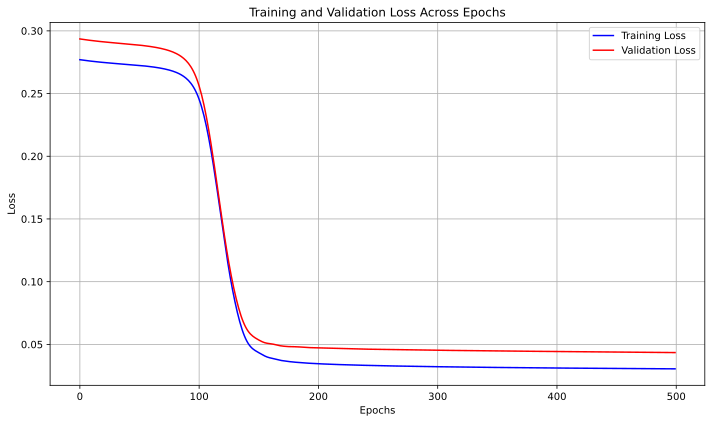

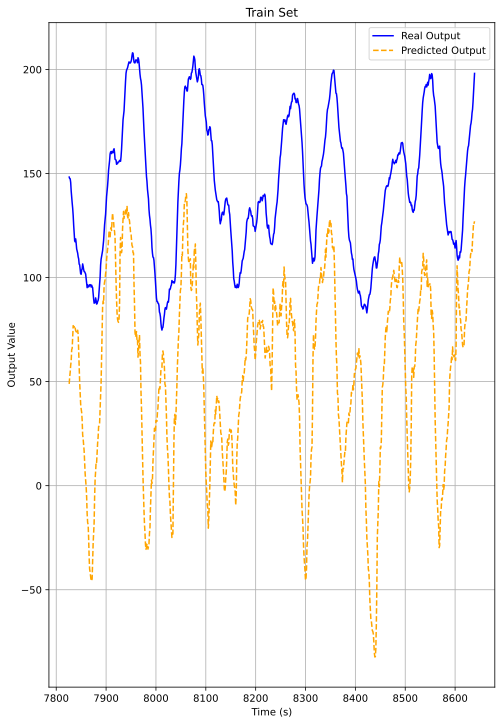

In [15]:
# --------------Plot identification results for S-----------------

#Training and Validation Loss Across Epochs
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), train_losses, label='Training Loss', color='blue')
plt.plot(range(epochs), val_losses, label='Validation Loss', color='red')  # Assuming val_losses are collected
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Across Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Model's Predictions vs Actual Output for the test set
fig, axes = plt.subplots(nrows=len(test_loader), ncols=1, figsize=(8, 12), sharex=True, sharey=True)

closed_loop_REN_2.to("cpu")

for u0_batch, _, _, u1_batch, y_batch, time in test_loader: # MH, I_rec (PID), R (noise + sat), I_sat (I_rec + R), CGM, time
    # u_batch.shape = batch_size   horizon   input_dim
    
    u0_batch, u1_batch, y_batch= ensure_3d(u0_batch), ensure_3d(u1_batch), ensure_3d(y_batch) # batch_size, time_horizon, input_dim
    u_batch = torch.cat((u0_batch, u1_batch), dim=2)  # concatenate along input dimension
    u_batch, y_batch = u_batch.to("cpu"), y_batch.to("cpu")
    

    closed_loop_REN_2.eval()
    _, y_hat = closed_loop_REN_2(x0, u_batch)
    
    loss_batch_val = MSE(y_batch, y_hat)

    loss_val_epoch += loss_batch_val.item()
    
    y_batch_np = scaler_glucose.denormalize(y_batch.detach().cpu()).numpy()
    y_hat_np = scaler_glucose.denormalize(y_hat.detach().cpu()).numpy()
    


plt.plot(time, y_batch_np[0, :, 0], label="Real Output", color="blue")
plt.plot(time, y_hat_np[0, :, 0], label="Predicted Output", linestyle="--", color="orange")
plt.title(f"Train Set")
plt.xlabel("Time (s)")
plt.ylabel("Output Value")
plt.legend()
plt.grid(True)
plt.show()